<h1>Analysis of provided dataset</h1>

In [1]:
import pandas as pd
df=pd.read_json("Appliances.json",lines=True)
df.head(3)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN


In [2]:
df["is_bad"]=df["overall"].apply(lambda x:1 if x==5 else 0)

In [3]:
df["reviewText"]=df["reviewText"].astype('str')

In [5]:
df["reviewText"]=df["reviewText"].astype('str')
df["nb_char"]=df["reviewText"].apply(lambda x:len(x))
df["nb_words"]=df["reviewText"].apply(lambda x: len(x.split(" ")))

In [7]:
df_n=df.sample(frac=0.03,replace=False,random_state=42)

<h1>Text Preprocessing</h1>

In [8]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)
df_n["review_clean"] = df_n["reviewText"].apply(lambda x: clean_text(x))


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df_n["sentiments"] = df_n["reviewText"].apply(lambda x: sid.polarity_scores(x))
df_n = pd.concat([df_n.drop(['sentiments'], axis=1), df_n['sentiments'].apply(pd.Series)], axis=1)

In [ ]:
df_n.head(3)

In [10]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_n["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df_n["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df_n = pd.concat([df_n, doc2vec_df], axis=1)

In [ ]:
# !pip3 install gensim

<h1>Tfidf vectorization</h1>

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df_n["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df_n.index
df_n = pd.concat([df_n, tfidf_df], axis=1)


In [12]:
df_n["is_bad"].value_counts(normalize = True)


1    0.691755
0    0.308245
Name: is_bad, dtype: float64

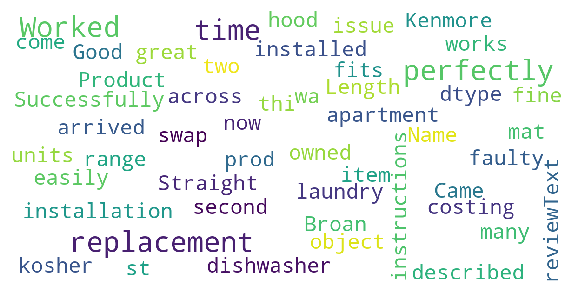

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 150,
        max_font_size = 20, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 10)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df_n["reviewText"])

In [15]:
df_n[df_n["nb_words"] >= 5].sort_values("pos", ascending = False)[["reviewText", "pos"]].head(10)


,reviewText,pos
596351,Perfect fit and great value,0.927
98424,"Perfect Universal fit, great value",0.927
373753,"Fit great, easy to clean.",0.924
291031,Fit perfect. Easy install. Thanks,0.923
571806,Perfect fit. Worked like a champ.,0.922
225912,"Perfect fit, works like a champ.",0.922
116223,"perfect fit, exactly like original!!",0.921
232174,Very nice well pleased thanks,0.920
304727,Work great - fit perfect!,0.914
532753,Fit like original easy replacement.,0.911


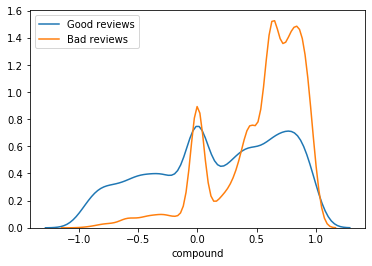

In [16]:
import seaborn as sns

for x in [0, 1]:
    subset = df_n[df_n['is_bad'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)


In [25]:
label = "is_bad"
ignore_cols = [label, "reviewText", "review_clean"]+list(df.columns)

features = [c for c in df_n.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_n[features], df_n[label], test_size = 0.20, random_state = 42)

In [26]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.052527
2,pos,0.047094
7,doc2vec_vector_3,0.031745
1,neu,0.031668
0,neg,0.029468
6,doc2vec_vector_2,0.028968
4,doc2vec_vector_0,0.027307
8,doc2vec_vector_4,0.027000
5,doc2vec_vector_1,0.025068
923,word_great,0.011316


<h1>Evaluation Matric</h1>

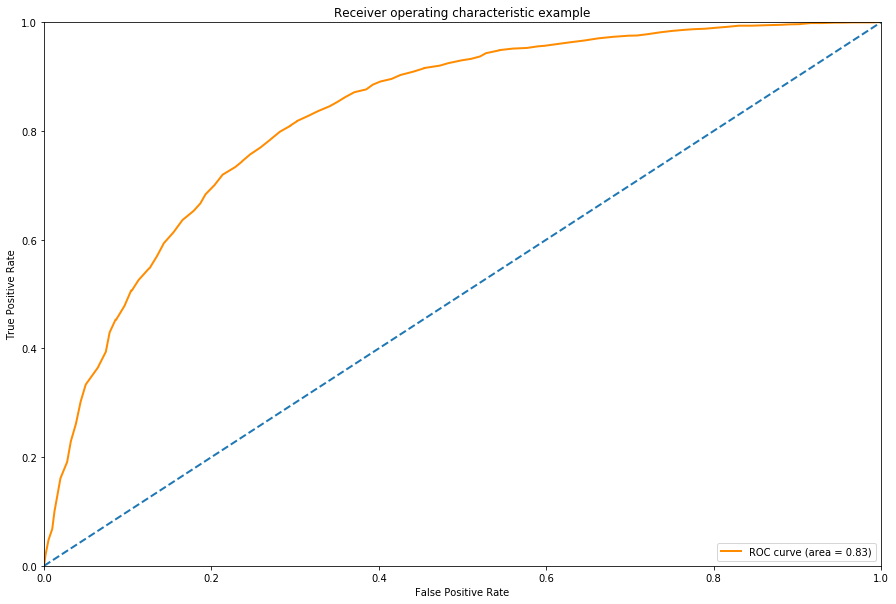

In [29]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.90')

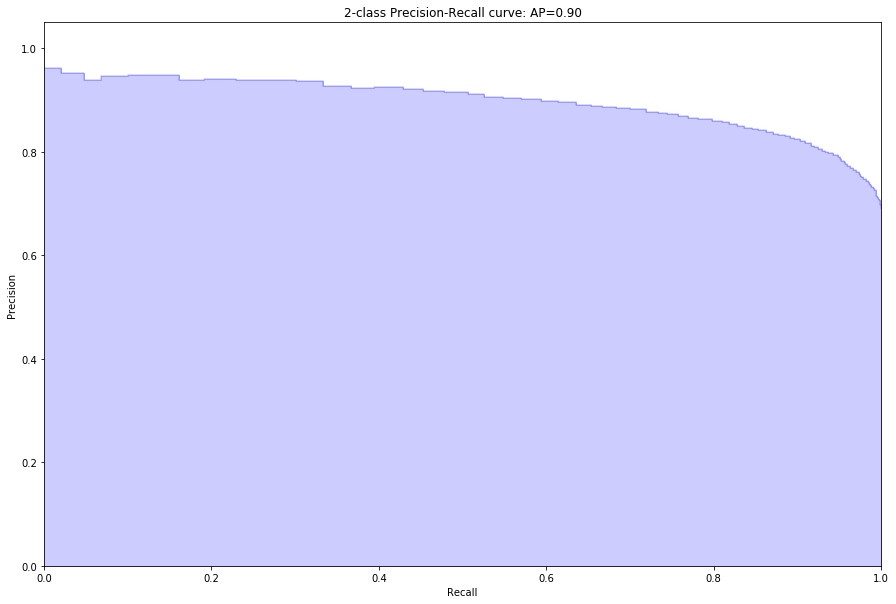

In [30]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA4AAAAJcCAYAAACov8q3AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOzdeXhU1f3H8feZyb4TAmFJ2HdIEBFURHFBRXFBwVpqbbXa1rVVfxZ3xX2tdrFVa11qtVorqKi4oYAbKKLssi9hXxJC9m3m/P44ExkwrJLcSfJ5Pc88c++dO3O/dzIh8+Gce46x1iIiIiIiIiJNn8/rAkRERERERKRhKACKiIiIiIg0EwqAIiIiIiIizYQCoIiIiIiISDOhACgiIiIiItJMKACKiIiIiIg0EwqAIiKNhDHmAmPMB17X4TVjTAdjTIkxxt+Ax+xkjLHGmKiGOmZ9MsYsNMYcfxDPa7KfQWPM8caYdV7XISJS3xQARUQOgjFmtTGmPBRENhljnjfGJNXnMa21L1lrT6nPY0Si0Hs9vHbdWptnrU2y1ga8rMsroSDa7ce8hrW2r7V22j6O84PQ21w/gyIiTYkCoIjIwTvTWpsEHAYMAG7yuJ6D4mWrVlNpUTsQer9FRMRLCoAiIj+StXYT8D4uCAJgjIk1xjxijMkzxmw2xjxpjIkPe/xsY8wcY0yRMWaFMWZEaHuqMeYZY8xGY8x6Y8w9tV0djTEXGWM+Cy0/YYx5JLwOY8ybxpjrQsvtjDETjDFbjTGrjDG/C9tvvDHmNWPMi8aYIuCi3c8pVMcLoeevMcbcaozxhdXxuTHmcWPMDmPMYmPMSbs9d2/n8Lkx5jFjTD4w3hjT1RjzsTEm3xizzRjzkjEmLbT/v4EOwFuh1tZxu7dMGWOmGWPuDr1usTHmA2NMRlg9vwidQ74x5rbdWxR3O+94Y8wfQ/vvMMZ8Fv5zAy4I/Uy3GWNuCXveYGPMDGNMYei8HzfGxIQ9bo0xVxpjlgHLQtv+bIxZG/oMzDbGHBu2v98Yc3Pos1EcejzbGPNJaJe5offj/ND+Z4Q+T4XGmC+MMblhr7XaGHODMWYeUGqMiQp/D0K1fx2qY7Mx5tHQU2uPVRg61tHhn8HQc/saYz40xhSEnnvzHt7XPf4+hGr7MuzneblxXVTjQuv/M66VfYcx5hNjTN+w133eGPN3Y8y7oRo/N8a0Mcb8yRizPfTZHLDbe3GTMWZR6PHnao9TR817/B0SEWnMFABFRH4kY0wWcBqwPGzzA0APXCjsBrQHbg/tPxh4AfgDkAYcB6wOPe95oCb0nAHAKcCldRz2ZeB8Y4wJvWaL0L6vGBfU3gLmho57EnCNMebUsOefDbwWOv5Ldbz+X4FUoAswDPgFcHHY40cCK4AM4A5gojEmfT/P4UhgJZAJ3AsY4H6gHdAbyAbGA1hrLwTyCLW2WmsfqqNWgJ+F6msNxADXh96XPsDfgQuAtqFzar+H1wB4BBgIDAHSgXFAMOzxoUBP3Ht6uzGmd2h7ALg29H4cHXr8it1ee1To3PuE1mfhPh/pwH+A/4WFkeuAscDpQArwK6DMWntc6PH+offjv6GA8yzwW6Al8BQwyRgTG3bsscBIIM1aW7NbXX8G/mytTQG6Aq+GttceKy10rBnhTzLGJANTgPdwP7tuwEfUbY+/D8DDQCVwqzGmO3Af8HNrbUXo8XeB7rif7Tf88PP6E+BW3HtfCcwI7ZeB+4w/utv+FwCnhs61R+i5u9jP3yERkcbJWqubbrrpptsB3nCBrQQoBizui29a6DEDlAJdw/Y/GlgVWn4KeKyO18zEfYGND9s2FpgaWr4I+CzsGHnAcaH1XwMfh5aPBPJ2e+2bgOdCy+OBT/Zybn6gCugTtu23wLSwOjYAJuzxr4AL9/Mc8vZ07NA+o4Bvd3uvh4etdwq951Gh9WnArWGPXwG8F1q+HXg57LGE0LkNr+O4PqAcF652f6z2mFm7nfNP93AO1wCvh61b4MR9nPf22mMDS4Cz97CfBbqFrT8B3L3bPkuAYWHv36/q+PwODy1/AtwJZOzhnKPCtoV/BseG/5z2cl57/X0IO1YB8B1w015eKy1UU2po/Xng6bDHrwa+C1vPAQp3O+/LwtZPB1aElo8H1u3P75BuuummW2O+6VoAEZGDN8paO8UYMwzXgpMBFAKtcEFjdqiBDtyX4NpRK7OByXW8XkcgGtgY9jwfsHb3Ha211hjzCu5L+Ce4FrAXw16nnTGmMOwpfuDTsPUfvGaYjFAda8K2rWHXlrP11lq72+Pt9vMcdjm2MSYT1wp1LJAc2n/7Xuqry6aw5TKgdkCeduHHs9aWGdf1tC4ZQByuZfOAjmOM6YFraToC97OPAmbv9tzdz/t64JJQjRbX0lfbdTV7H3WE6wj80hhzddi2mNDr1nns3VwC3AUsNsasAu601r69H8fd3xr39fuAtXa1MWYqLpD97fudXNfhe4HzQq9T2xqbAewILW8OO1Z5Heu7D84U/l7Ufm53tz+/QyIijZK6gIqI/EjW2um4lojaa/K24b549rXWpoVuqdYNGAPuC2jXOl5qLa71LCPseSnW2r517AuuG+gYY0xHXIvFhLDXWRX2GmnW2mRr7enhZe/llLYB1bgvwbU6AOvD1tubsG/zocc37Oc57H7s+0LbcqzrhvhzXEDYn1r3ZSOQVbsSuu6s5R723QZUUPfPZl+eABYD3UPncDO7ngOEnUfoer9xuO6LLay1abhAU/ucPX1G6rIWuHe3n3eCtfbluo69O2vtMmvtWFwXyweB14wxiXt7Tthxu+xHffv6fcAYMxLXKvgRrktorZ/huisPx3Xf7VT7lP047p5khy3Xfm53tz+/QyIijZICoIjIofEn4GRjTH9rbRB4GnjMGNMawBjTPuz6oWeAi40xJxljfKHHellrNwIfAH80xqSEHusaamH8AWvtt7gv1/8E3rfW1rZWfAUUhwbXiA8NKNLPGDNof07EuukVXgXuNcYkhwLmdexsYQQXFn5njIk2xpyHu3Zv8oGeQ0gyrjvtDmNMe9y1keE2s39Boy6vAWcaY4YYNyjLePYQHkI/t2eBR0MDgPhDA5/E1rV/HedQBJQYY3oBl+/H/jXAViDKGHM7rgWw1j+Bu40x3Y2Ta4ypDa67vx9PA5cZY44M7ZtojBkZukZvn4wxPzfGtAqdf+1nKBiqLcie3/u3gbbGmGuMG+Ql2Rhz5O477ev3wbgBe/6Ju070l7ifV23QSsb9h0I+rhXxvv05p3240hiTFbpm9Rbgv3Xs86N+h0REIpkCoIjIIWCt3Yob2KV2YIsbcIPCzDRupM0puMFDsNZ+hRuw5DFcq890dra2/QLXfW8Rrhvka7jBS/bkP7jWkf+E1RIAzsANuLGKnSEx9QBO6WrcdVsrgc9Cr/9s2ONf4gbm2IbrojfGWlvbtfJAz+FO4HDce/EOMHG3x+/HDRBSGOo2ud+stQtD5/IKrjWwBNiCCxV1uR6YjxugpQDXIrY/fyuvx7VWFePCTl2hItz7uMFTluK6IVawa9fER3Eh/ANcsHwGqB2NdDzwr9D78RNr7de4a0Afx73fy6ljZNe9GAEsNMaU4Lri/tRaW26tLcP9bD8PHeuo8CdZa4uBk4EzcV1jlwEn7OEYe/x9AP4BvGmtnRz6DF0C/DMUeF8IvT/rcZ+nmQdwXnvyH9z7uhLXhfWe3Xc4RL9DIiIRyex6CYeIiMjeGWMuAi611g71upYDZYxJwrVydbfWrvK6HmlYxpjVuM/uFK9rERHxiloARUSkSTPGnGmMSQhd1/YIroVvtbdViYiIeKPeAqAx5lljzBZjzII9PG6MMX8xxiw3xswzxhxeX7WIiEizdjZuoI8NuG6rP7Xq/iIiIs1UvXUBNcYch7vW4gVrbb86Hj8dd13G6bjR6/5srf3BxeMiIiIiIiJyaNRbC6C19hPcBfR7cjYuHFpr7UwgzRizt0ECRERERERE5EfwciL49uw64tm60LaNu+9ojPkN8BuAxMTEgb169WqQAkVEREREpB4EqyBQBcEg2JrQcvXOW6AagjUH+qLQxHv4rwu0ZrtNoWrT8m3W2lYH8xpeBsD9Zq39B26YaI444gj79ddfe1yRiIiIiEgTE6yBQCXUVLr72ltNBVSXQFURVBVDZdHO5arQck1FWHir2vU+fLmyCErWgw3U33n4oiEqDqLiwR+3czkqLrQetuzbSxzyRbnX8kWDP3rncl3rph46VkbFQ0ZfrPFjjJvCdktJgJumFPHsZSevOeiXPWQFHrj1QHbYelZom4iIiIhI02QtlOdD6UYo3QQ1ZQf+/EAl1JRDoMIFr5pydx8IW67z8cq6bzWVbl8brJ9zrktiG0juALGpENcSktpCYlu3PTG0nNAKjH//X/P7UHcAz4lg1lr+N3sdb83dwHMXDSLK76N1JjzTFZ697OBf18sAOAm4yhjzCm4QmB3W2h90/xQRERERiXjV5VC+1d1KNoYCXui2y/om1xIWiYwP/LG73qLi3H1McuiWErqFlmNDy1Hxu7WQxYS1lMXsbDGLToSkLIiK9fpsI9ragjJufn0+ny7bBsC7CzZxZv92h+S16y0AGmNeBo4HMowx64A7gGgAa+2TwGTcCKDLgTLg4vqqRURERETkgASqoGwrlG2B8i3u/vv18PvQcnXJ/r92bOrOVq6Y5AOv7ftujfvZzTEq3gUuf1xYsKsj5O2tO6Q0iEDQ8sKM1Tz8/hLKqgKkJURz+xl9OCP30I2VWW8/ZWvt2H08boEr6+v4IiIiItLMBWtc98fqUqguc90tq8vcekV+KNTVcSvfAhXbD+xYvmjXZTG+1a7dGBPbhnVvDHVxjE6on/OVRm35lmJumDCf2WvcZ29kblvGn9mXVsmHtrVUMV9EREREIlOgGiq3u2vmyvOhosAFt/J8d19RELa83QW72pBXU+Za8Q6W8btAl9Aa4luHLe92Xxv6YlMhNFCHyMH4fHk+s9dsp1VyLPeM6sepfdvUy3EUAEVERESk4dRUhK6F2wxloduelit3/LhjGR9EJbgWt93v41qGAlwdt/jWEJ9ePyM7ioTZUV5Nanw0ABce1ZGSyhp+fmRHUhOi6+2YCoAiIiIicmhY666LK8qD4ry678s2H8ALGohLd2EsriXEtwy7321bXIvQYCRhQc8fo1Y5iUgV1QH+NGUZ//lyDe9ecxzt0+Lx+QxXntCt3o+tACgiIiIi+y9YAztWw/alULgMCkL3RatdwAtU7v35xh+6Fi4TEkK3xEx3bVz4ekKmC3VqhZMm5suV+dw4cT6rtpViDHy2bCvnD+rQYMdXABQRERGRXdkgFK93Ia826G1fCtuXwY6VLgTuSVwLN79bcgdIqeM+sW2TmadN5EAUV1Tz0HtL+PdMN4d799ZJPDgml8M7tGjQOhQARURERJqjikLYsSrUcrfateoVrXYBr3C5u1ZvT5KzoUUPaNHd3ad1h7QubvvBTGsg0sR9taqAa175lg07KojyGa44vitXntiN2KiG/88QBUARERGRxiZQHRoRMzQKZnUx1FRCsMqNfBmodPfh6+Xbdoa8otX7HmAlIXPXgJdeG/S6ahoDkQOUFBvFluJKctqn8tCYXHq3TfGsFgVAERERES8Fqt2omGWbd05psK9pD6qKfvxxoxMhpROkdg7dd9p5n9YdYr37girS2Flr+XrNdgZ1SgegT7sUXv7NUQzITiPK7+11rQqAIiIiIvXBBqFsK5RsgNINULLeLZeELZducBOPHyjj23UUzJgU8Me6US/9MeAL3Ydvi0l1Ya828MW31AiZIvVgc1EFt72xgA8WbebJnx/OiH5tAb4Pg15TABQRERE5WGXbYPsSKFgMBUvctXOloZBXunHvg6XUMr7QCJhtdpvmoOWepz+ITdXomCIRxlrLq1+v5Z53vqO4ooak2CgqqoNel/UDCoAiIiIiexOodgOj1Ia8gsWh0LfEdcvcm7iWkNQOktqH7ttB4m7rCa3Bp69kIo1ZXn4ZN06cxxcr3L8JJ/Zqzb3n9KNtarzHlf2Q/rURERERqal0E5XXjopZuGJn4NuxYs8tedFJkN4L0nu6+7TukJwVCnptISquQU9DRBrezJX5XPzcLMqrA7RIiGb8WX05q387TIR2sVYAFBERkaYvUOUmKd9luoOwKRBKNuz9+SkdoUXPXcNeei8X8iL0S56INIzcrFQykmM4LLsF48/sQ8ukWK9L2isFQBEREWn8rIXSTa7lrnC5a7X7PuitdoOuYPf8fON3c9h9PxJm552Br0V3TXsgIt+rqgnyry9WM/bIDiTFRpEQE8VbVw0lLSHG69L2iwKgiIiINA7BGteKV7jCBbztoaBXGLrVlO35ucYHyR12ne4gfDk5S9fhicg+zV1byA0T5rF4UzF5BWXcPaofQKMJf6AAKCIiIpGkuswNuFIYFuxqQ17R6r2PqhnXElp0g9SubrLy7+e36+wGXfFHN9RZiEgTU14V4LEpS/nnpysJWujYMoHTctp4XdZBUQAUERGRhlNV4ua9K9vsrsELD3iFK9zUCXuTlOXCXVpXSOu2czm1K8SlNcw5iEizMmNFPjdNnMfq/DJ8Bn59bGeuO7kn8TF+r0s7KAqAIiIicmhUl7pumduXQuEyKFy5M+yVbXG3vXXTBPBFu26ZaWEtebW3lM4QHXlDqotI07V4UxFjn54JQM/MZB4ck8th2Y37P5sUAEVERGT/WOsCXNFaF/C2Lw3dQssl6/f9GlFxkJDp5r5L7rBrC15aVzcQi69x/q+6iDQ9vdqkMPrwLLLT47ni+G7ERPm8LulHUwAUERFpLqrLoHjtzltloeuSWV3iWu+qS3au17m9lL2OpOmLdiGuRQ83H15aVzdNQkJrd0vMdPPmadoEEYlQ+SWV3PPOd1x8TCdys1xL3yPn5UbsnH4HQwFQRESkKQhUuxa44jwX7opqg17ezsBXUfDjjxMVD4ltdoa8Fj3cNAktekBKB42kKSKNkrWWSXM3cOdbiygorWJ1fikTLx+CMaZJhT9QABQREWmcyvNh0yyY8zhs/sbNgbe31jkAf4wbRCU5293iW7oWuegkiAndRyeGLYdtj0mCqAR1zxSRJmfjjnJufX0BHy3eAsDRXVrywOicJhf8aikAioiIRLrqctg6BzZ9BRu/cveFy3+4X3i4S86GlGx3nV3tekIrNx+eiIgQDFpembWW+yd/R3FlDcmxUdwysjfnD8pusuEPFABFREQiiw1CweKdQW/TV7B17g/nv4uKh8yB0GYwtBkE3UdrnjsRkQOQX1r1ffgb3rs194zKoU1qnNdl1TsFQBERkUiQvxi+uB1WvwdVxbs+ZnyQkePCXtvB7j6jn663ExE5QIGg6yrv9xlaJcdy96h++H2GM3LbNulWv3D6yyEiIuKl0s0wYzzMexpswG1Lzoa2R4Za9wZD5uEQk+xpmSIijd2STcWMmzCPM3PbcumxXQAYNaC9x1U1PAVAERERL1SXwtd/hFkPu2kWjA9yfwNH3gwpHb2uTkSkyaiqCfK3qcv5+7TlVAcsxRXVXDSkE1H+5nlNtAKgiIhIQ7EW8hfCqndh9mNQutFt73ImHPcAtOzjbX0iIk3MnLWFjHttLks3lwDw86M6cMOIXs02/IECoIiISP0q2QBrpsCaDyFvSmi6hpDMI2DYw5B9vGfliYg0RZU1AR5+bwnPfr6KoIXOGYncf24OR3Vp6XVpnlMAFBEROZTKC2DjDBf41nwI+Yt2fTyxDXQ8GbqNcjdNyyAicshF+XzMztsOwG+HdeHa4T2Ii9Y8pqAAKCIicuBsEIrXQv53bsqGgsVQEFou27LrvtGJkDXMhb6Ow6FlX2gmI82JiDSkoopqKquDtEqOxe8zPDymP2VVNeRmpXldWkRRABQREdmb6jLY/I2bj2/z7FDQWwI1ZXXvH5UArXKhw0ku9LU7GvwxDVuziEgzM2XRZm55Yz5926XyzC+PwBhDt9ZJXpcVkRQARUREagUDrsvmxi93TsK+bcHO6RnCJWRCei9o2dvdp4fuk7PUrVNEpIFsK6nkzrcW8dbcDQC0S6uiuLKGlLhojyuLXAqAIiLSPFnrunGGh73Ns930DOGMH1od5iZgzzzCTcCe3gviWnhTt4iIYK3lzTkbuPOthWwvqyY+2s8fTu3JL4d0wu9TN/u9UQAUEZHmo3QzrJrsbus+hbLNP9wntfPOCdjbDIbMAe46PhERiQjBoOW3L87mw0Xu3/Ch3TK4/9wcstMTPK6scVAAFBGRpssG3fV7K9+BVe/Aplm7Ph6XvjPotR0MbQZBQmtvahURkf3i87nr+2auzOe2kX0474gsjAbX2m8KgCIi0nRUl0LBUjdQy5opsPrdXefd88dChxOh80jodAqkddOInCIijcCqbaVsKargyNA8fr8/qTsXDelEZkqcx5U1PgqAIiLSuNggFK8LTb2wBLYvcfcFi6Fk3Q/3T86GLiNd6OtwIkSri5CISGNREwjyzGerePTDpaTGR/PhdcNIjY8mLtqvef0OkgKgiIhEpqqSsHAXCnjbl8D2pVBTXvdz/DGuVa9FT9eds8sZbtAWtfKJiDQ6izYUccOEecxfvwOAod0zwHpcVBOgACgiIpEjUAVrp8G06yB/4Z73S8iE9J4u6KX32rmc2gl8+tMmItKYVdYEePzj5TwxbQU1QUv7tHjuPacfx/fUNdqHgv5KioiItyqLYPV7sPwNN1hLVdHOx2KS3WTq6b1CYS8U9OLSvKtXRETq1W//PZtpS7YC8IujOzJuRC+SYhVbDhW9kyIi0vBKN8GKSS705X3kWv5qZeRAt1HQ8yeu+6aIiDQrvzqmM3kFZTxwbi6DO6d7XU6TowAoIiL1z1rIX+Ra+Ja/ARtnsvNCDgPth0K3c6Db2ZDW1ctKRUSkgX22bBvz1hdyxfHdADiuRys+uOY4ovw+jytrmhQARUSkfuxYBWs+grUfQ97Hu0667o91XTu7jYKuZ2ruPRGRZmhHWTX3Tl7Eq1+vwxg3oXtuluvir/BXfxQARUTk0CjZuDPs5X0MRat3fTyxDXQY7kJfp1MhJsmTMkVExHvvLdjEbW8uYGtxJTFRPn5/Und6t03xuqxmQQFQREQOTnkBrJu2M/AVfLfr47FpkH2Cm3uvw4mQ3lvTMYiINHNbiisYP2khk+dvAmBgxxY8ODqXbq31n4INRQFQRET2n7WwbjrM/hOsfMtNyl4rKgGyjtsZ+FodBj5N0isiIjs98v4SJs/fREKMnxtG9OLCozri8+k/BxuSAqCIiOxbTSUs+S/Mfgy2znHbfNHQ/thQ4DvJTbzuj/G2ThERiTjWWkyoB8gfTu1FaVWAm07rRVaLBI8ra54UAEVEZM/KtsLcJ2Hu393UDQDxreCwK6D/5ZCY6W19IiISsYJBy4tfruHteRt56dIjifb7aJUcy99+drjXpTVrCoAiIvJD2xa4bp7fvQiBSrctIwcGXgu9xkJUnLf1iYhIRFuxtYQbJ8xj1urtAExZtJnTctp6XJWAAqCIiNigm6Nv/Weh2+e7juDZ5QwX/LJP0CAuIiKyV9WBIE9/upI/TVlGVU2QjKRY7hnVlxH9FP4ihQKgiEhzU1MBm752YW9DKPBVFu66T2wq9P45DPgdpPfwpk4REWlUFqzfwQ0T5rFwQxEA5w3M4taRfUhNiPa4MgmnACgi0hxs/gaWvOpC3+ZZEKja9fGkLMg6FtoPdbeWfTWCp4iIHJC56wpZuKGIrBbx3H9uDsd2b+V1SVIHBUARkaaqutyN3Dn3Cdj0VdgDxl3PVxv22g+FlA6elSkiIo1XfkklLZNiARg7qAOV1UHOH5RNYqxiRqTST0ZEpKkpWArznoSFz0OFu/ie2DTocyF0OhXaDYG4Fp6WKCIijVtpZQ0Pv7+E12av493fH0t2egI+n+FXQzt7XZrsgwKgiEhTsfIdN09f3kc7t7UZBP2vgJ7nQ3S8d7WJiEiTMX3pVm6eOJ/1heVE+QyzVheQna45/RoLBUARkcauqhg+ugoWveDWo+Kh18/gsMshc6C3tYmISJNRWFbF3W9/x4Rv1gHQr30KD47OpW+7VI8rkwOhACgi0pht/Aom/wwKV7jgN+ROyPk1xKV5XZmIiDQhny/fxu9f+ZZtJVXERPm4dngPfn1sZ6L8Pq9LkwOkACgi0hgFAzDrQfjiDgjWQKv+MPJlaNnb68pERKQJykiKZUd5NYM7pfPA6By6tEryuiQ5SAqAIiKNTdFaePdCWDfdrQ+8DobeB1Gx3tYlIiJNhrWWz5ZvY2i3DIwx9GyTzITLh9CvXSo+n/G6PPkRFABFRBqDmkrY/LULfV8/4kb3TMiE016ATqd4XZ2IiDQhawvKuPn1+Xy6bBt/HTuAM/u3AyA3S5cXNAUKgCIikaiyCDZ8Aes/hXWfunn8ApU7H+8yEk59FhJae1ejiIg0KYGg5YUZq3n4/SWUVQVIS4jGr9a+JkcBUEQkEpRu3hn21n8KW+eCDe66T0Y/aH8sdDwFup0NRn+URUTk0Fi+pZhxr83jm7xCAEbmtuXOs/qSkaTLC5oaBUAREa9Ul8I3f4GFz8H2Zbs+5ouCNoNd4Ms6FtodA/Hp3tQpIiJN2hfLt3HRc7OoCgRpnRzL3aP6cWrfNl6XJfVEAVBEpKEFqmHBszBjPJRuctuiE6Ht0S7stT8W2h4J0ZpUV0RE6t+ADi1o3yKewZ3SuXlkb1Ljo70uSeqRAqCISEOxFpZNhM9uhu1L3bbMgTD0Xsg+Efz6gysiIvWvojrAPz5ZyUXHdCIlLpr4GD9vXT2UpFhFg+ZAP2URkYawdhp8coMbzAUgrZsLfj3GgNEkuiIi0jC+XJnPjRPns2pbKZuKKrjvnBwAhb9mRD9pEZH6tGUufHYTrHrXrSdkwtF3QM6lavETEZEGU1xRzYPvLebFmXkAdG+dxJiBWR5XJV5QABQRqQ/l+fDpjTD/GcBCTDIMGgeHXwMxSV5XJyIizcjUxVu45fX5bNhRQZTPcMUJ3bjyhK7ERvm9Lk08oAAoInIo2SAseB4+GQcV+eCLhsOugCNvgYRWXv8ZyyUAACAASURBVFcnIiLNzKINRVz8/CwAcrNSeXB0Lr3bpnhclXhJAVBE5FDZOh+mXA4bPnfr2SfASX+Dlr29rUtERJqtPu1SGDu4A50zEvjVMZ2J8uu68+ZOAVBE5MeqKoEZd8Lsx8AGIKE1HP8o9PqZJmsXEZEGtbmogtvfXMBlw7oyoEMLAO4/N8fjqiSSKACKiBwsa2H5GzD191C8FjDQ/wo3umdcmtfViYhIM2Kt5dWv13LPO99RXFHD1uJKJl5xjNdlSQRSABQRORjbFsD0P8Dq99x65kAY/gS0GeRtXSIi0uzk5Zdx48R5fLEiH4ATe7Xm3nP6eVyVRCoFQBGRA1G6CT6/HRY84wZ8iUlxLX79LwefRlMTEZGGEwhanvt8FX/8YCnl1QHSE2O448w+nNW/HUaXIMgeKACKiOyP6jKY/Sh89SBUl4Dxw2FXujn9NLqniIh4YHtZFX/9eDnl1QHOPqwdt5/Rh5ZJsV6XJRFOAVBEZG9sEBb9Gz67BUrWu21dz4LjHoL0nt7WJiIizU5VTRCfgSi/j4ykWO47J4fYKB/D+2R6XZo0EgqAIiJ1qamAJf91rX5b57ltrQ+HYY9AhxO8rU1ERJqluWsLuWHCPEYNaM9lw7oCMDK3rcdVSWOjACgiEq5oDcx9EuY97SZyB0jKgmPvg94XgNH8SSIi0rDKqwL8acpSnv50JUELr3+znkuHak4/OTgKgCIi1kLexzDncVgxyXX7BGg9AA67CnqNheh4b2sUEZFmaebKfG6cMI/V+WX4DPzmuC5cO7yHwp8cNAVAEWm+Kotg0Qsw529QsNht80VDz5/CgKug7VGayF1ERDxRUR3g7rcX8dKXeQD0zEzmwTG5HJateWblx1EAFJHmJ/87F/oW/suN6AmQ1A5yL4PcX0NiG2/rExGRZi/G72Pp5mKi/YarTujO5cd3JSZKrX7y4ykAikjzYC2smw5f3gdrPty5PWuYa+3rejb4o72rT0REmr2C0iqqA0EyU+Lw+QwPj+lPZU2Qnm2SvS5NmhAFQBFp2qyFNVNg5l2w/jO3LSoB+lzo5vFrleNtfSIi0uxZa3lr3kbGT1pIv/ap/OviQRhj6JSR6HVp0gQpAIpI02QtrJoMM++GjV+6bXEt4PBrYMDVbllERMRjm3ZUcOsb85ny3RYAagJBSiprSI5TrxSpHwqAItK02CAsfxNm3gNbvnHb4jNg4P/BYVdAbIq39YmIiADBoOWVWWu5f/J3FFfWkBwbxS0je3P+oGyMBiCTeqQAKCJNQ7AGlr4GX94L2xa4bYlt4Ig/QP/fQrS60YiISGQIBi2/fO4rPl22DYDhvTO5Z1Q/2qTGeVyZNAcKgCLSuFWXwvxn4ZvHYMcqty2pPQy6AXIu1fx9IiIScXw+w2HZaSzaUMT4s/pyRm5btfpJg1EAFJHGqWwLfPu4m86hosBtS+vqWvz6XgRRsZ6WJyIiEm7JpmK2lVRyTLcMAK46sRsXH9OZ9MQYjyuT5kYBUEQal+3L4Os/wqJ/QU2F29b2SBf8uo0Cn9/b+kRERMJU1gT4+9QV/H3aclLjY5hy3XGkJcQQG+UnNkp/s6ThKQCKSOOwYSZ8/TAsex2wbluXM2HQH6D9UFDXGRERiTDf5m3nhgnzWLq5BIAR/TKJ8msyd/GWAqCIRC4bhBVvu+BXO4efPwZ6/xyO+D9o2cfb+kREROpQVlXDHz9YyrOfr8Ja6JyRyAPn5nBkl5ZelyaiACgiEaqiEF45BvIXufXYVOh/OQz4HSS19bY2ERGRvfjtv2fz6bJt+H2GXx/XhWuGdycuWt09JTIoAIpI5Fn2Bnx0BZRudOvHPeymcohJ9rYuERGR/XD5sK7kl1Tx4OhccrJSvS5HZBcKgCISOcq2wEdXw9JX3Xrbo+HUZ6FlL2/rEhER2YsPF21mwfodXHtyDwCGdMvg7auH4vPp+nSJPAqAIuI9a+G7l2Dq792UDtGJMPR+OOwKjeopIiIRa1tJJeMnLeTtea7Hyom9WtM/Ow1A4U8ilgKgiHirdBO8fwmsmuzWOwyHU56G1E6eliUiIrIn1lremLOeO99aRGFZNfHRfsaN6Em/9uruKZFPAVBEvGEtrHwH3jzbjfbpi4bhT0K/izWlg4iIRKwNheXc8vp8pi7ZCsCx3TO475wcstMTPK5MZP8oAIpIw9s6D6b9H+RNcetp3eDM/0Hrw7ytS0REZB/+NGUpU5dsJSUuitvO6MOYgVkY/celNCIKgCLScEo3w+e3wYJnXKtfbBocfYe71s8f43V1IiIidQoG7ffX9N0wohdBC+NO7UnrlDiPKxM5cL76fHFjzAhjzBJjzHJjzI11PN7BGDPVGPOtMWaeMeb0+qxHRDxSUwFfPgDPdof5TwMGBlwNlyyHgdco/ImISESqCQR5cvoKznniC6pqggC0TIrlkfP6K/xJo1VvLYDGGD/wN+BkYB0wyxgzyVq7KGy3W4FXrbVPGGP6AJOBTvVVk4g0MGthyavw6Q1QtMZt63KGm9dPUzuIiEgEW7ShiHET5rJgfREAU5ds4dS+bTyuSuTHq88uoIOB5dbalQDGmFeAs4HwAGiBlNByKrChHusRkYa0aRZMvQY2fOHWM3Lg+Eeh43Bv6xIREdmLypoAj3+8nCemraAmaGmfFs995+YwrEcrr0sTOSTqMwC2B9aGra8Djtxtn/HAB8aYq4FEoM5vhsaY3wC/AejQocMhL1REDiFrYc7fXPizAUhoDcfcA/1+pTn9REQkon2Tt51xr81j+ZYSAH55dEf+MKIXSbEaNkOaDq8/zWOB5621fzTGHA382xjTz1obDN/JWvsP4B8ARxxxhPWgThHZH4Eq+Oiq0HV+wOHXwJA7ITZl788TERGJAMs2F7N8SwldWiXy4OhcBnVK97okkUOuPgPgeiA7bD0rtC3cJcAIAGvtDGNMHJABbKnHukSkPpRtgUmjYf1nEBUHpzwLvcd6XZWIiMhebdpRQZtUN6DLT47IJmjhnAHtiYtWrxVpmupzFNBZQHdjTGdjTAzwU2DSbvvkAScBGGN6A3HA1nqsSUTqw5Y58OIgF/6S2sP5nyr8iYhIRNtRVs241+Zy/CNTWb2tFABjDGMHd1D4kyat3loArbU1xpirgPcBP/CstXahMeYu4Gtr7STg/4CnjTHX4gaEuchaqy6eIo3J0gnw7i+gpgzaHglnvQ5Jbb2uSkREZI/eW7CJ295cwNbiSmKifMxbv4NOGYlelyXSIOr1GkBr7WTc1A7h224PW14EHFOfNYhIPbFBmHEXzLjTrff5BZz8lOv+KSIiEoG2FlcyftJC3pm/EYAjOrbggdG5dGud5HFlIg3H60FgRKQxqiqB934JyyaC8bl5/QZeC8Z4XZmIiEidpi7ZwjWvzGFHeTUJMX5uGNGLC4/qiM+nv13SvCgAisiB2bEa3jwbts6D2FQY+Qp0HuF1VSIiInuV3SKe8qoAx/VoxX3n9COrRYLXJYl4QgFQRPbfuk9h0rlQvg1a9IBRkyC9p9dViYiI/EAwaJny3WZO7pOJMYZurZOZdPUx9MxMxqjHijRj9TkKqIg0FdbC3Cfhfye58NfpVPjZTIU/ERGJSCu2lnD+P2bwm3/P5s05G77f3qtNisKfNHtqARSRvauphI+uhAXPuPWB18JxD4FP/3yIiEhkqQ4E+ccnK/nzR8uoqgnSKjmW5Dj9vRIJp98IEdmz4vXw1mjY+KUb3fPkp6HPz72uSkRE5AcWrN/BDRPmsXBDEQDnDczi1pF9SE2I9rgykciiACgidVv3Gbw1Bso2Q3IHOPt1yDzc66pERER+4JOlW7n4+VkEgpasFvHcf24Ox3Zv5XVZIhFJAVBEdlV7vd/U30GwBrJPgDP+Cwn6QyoiIpFpcOd0Omckcmz3DK4/pSeJsfqKK7In+u0QkZ10vZ+IiDQCJZU1/G3qci47riupCdHERft5++qhxEX7vS5NJOLpW52IOEVr4O3zdb2fiIhEtOlLt3LzxPmsLyxne2kVD4zOBVD4E9lPCoAizZ21MO8fMP16qC7R9X4iIhKRCsuquOvtRUz8Zj0AOe1T+cXRnbwtSqQRUgAUac6K8uCDS2HNh269xxg46QlIyPC2LhERkTCT52/k9jcXsK2kitgoH9ed3INLhnYmyq8prUUOlAKgSHNkLcx/BqZfB1XFENcShv8dev7E68pERER2sWD9Dq546RvADfbywLk5dGmV5HFVIo2XAqBIc1O8zrX6rX7frXc7B4Y/AYmZ3tYlIiJSh37tU7loSCe6tk7igsEd8PmM1yWJNGoKgCLNhbWw4DmYdi1UFUFcOpz4OPT6KRj9MRURkciwtqCMW95YwO9O7MYRndIBGH9WX4+rEmk6FABFmoPi9fDhr2HVu26969lw8pOQ2MbbukREREICQcsLM1bz0HtLKK8OUFZZw2uXD/G6LJEmRwFQpKlb/ApMuQwqd0BsGpz4V+h9gVr9REQkYizfUsy41+bxTV4hAGf2b8cdZ/bxuCqRpkkBUKSpsha+uANm3u3Wu5wBJz8FSe28rUtERCSkOhDkqekr+MtHy6kKBGmdHMu95+Rwch9dly5SXxQARZqimgp472JY8goYHxz/JxhwlVr9REQkohSVV/PMZ6uoCgT56aBsbjq9N6nx0V6XJdKkKQCKNDVlW+CNUbBxBkQnwRn/hS6ne12ViIgIABXVAfw+Q7TfR8ukWB4cnUtibBTHdNMctCINQbNnijQl+YvgP0e58JecDWM/V/gTEZGI8eXKfE7786c8NX3F99tO6dtG4U+kASkAijQVa6bAy0NgxyrIPAJ+9iW0yvW6KhEREYorqrn1jfmc/4+ZrNpWynsLN1ETCHpdlkizpC6gIk3BvKdhyuVgA9D9XDjt3xCd4HVVIiIiTF28hVten8+GHRVE+QxXntCNK07oSpRf7RAiXlAAFGnsPr9950ifg8bBsfe7gV9EREQ8VF4V4ObX5/P6t+sByM1K5aExufRqk+JxZSLNmwKgSGNlg/DFnTvD38lPQ+6l3tYkIiISEhvlY+OOcmKjfFx/Sk8uPqaTWv1EIoACoEhjVFUC7/4Clr/uWvtO/KvCn4iIeG5zUQWBoKVdWjw+n+HhMf0JBC2dMhK9Lk1EQhQARRqbwpXw5tmwbQHEpsLIV6DzCK+rEhGRZsxay39nreXeyd+Rm5XKi5cciTGG7HRdjy4SaRQARRqTvI/hrfOgogBa9IRRkyC9h9dViYhIM5aXX8aNE+fxxYp8AOKi/JRVBUiM1ddMkUik30yRxsBa+PZxmHatG+mz8+kw8j+uBVBERMQDgaDluc9X8cgHS6ioDpKeGMMdZ/bhrP7tMMZ4XZ6I7IECoEikK17vgt/S/7n1wTfBMXeDz+9tXSIi0mwFg5axT8/kq1UFAJx9WDtuP6MPLZNiPa5MRPZFAVAkUgWq4du/wBfjoboEohLglH9C77FeVyYiIs2cz2c4pmsGefll3HtOP07qnel1SSKynxQARSLR2unw0ZWQv9CtdzsHTngMUjp6W5eIiDRbc9cWUlBWxQk9WwNw+fFduXhoJ1Lioj2uTEQOhAKgSCQp3QTT/wDfvejW07q6KR46n+ZtXSIi0myVVwV49MMlPPPZKtISYphy3TDSE2OIifIRE6V5/UQaGwVAkUgQrIE5f4fPb4OqIoiKc9f6DRrnlkVERDwwY0U+N06cx5r8MnwGzhuYRXy0rkEXacwUAEW8tv4L+OgK2DrXrXcZCSf8BdK6eFuXiIg0W0UV1dw/eTEvf5UHQK82yTw0JpfcrDSPKxORH0sBUMQrZVvgkxth4XNuPaUTnPgX6Hqmp2WJiIj89oXZzFiZT7TfcPWJ3blsWFd19xRpIhQARRqatTDvKfj0JqgsBH8MDLoBBt8I0QleVyciIsI1w7tT+V6AB0bn0iMz2etyROQQUgAUaWgz7oIZ491yp1PdIC8tuntakoiINF/WWibN3cB3G4u58bReABzZpSUTLh+iCd1FmiAFQJGGtHIyzLgTMHD6v6HXz0B/XEVExCMbd5Rz6+sL+GjxFgBOz2nz/XV+Cn8iTZMCoEhDKVwJky8ALAy9F3pf4HVFIiLSTAWDlpdn5XH/5MWUVNaQHBfFbSP7kNM+1evSRKSeKQCKNITqcpg02l3z1/Usd72fiIiIB1ZvK+XGifOYubIAgJP7ZHLPqH5kpmjaIZHmQAFQpL5ZCx9dDlvnQFo3GPEvMBpJTUREvPHk9BXMXFlAy8QY7jy7LyNz2qq7p0gzogAoUt/mPQUL/wVR8XDWRIjTHEoiItKwqgNBov3uPx9vPK0XMVE+rh3egxaJMR5XJiINTc0QIvVp45fw8e/c8ilPQ6scb+sREZFmpbImwKMfLuWsxz+nsiYAQFpCDHed3U/hT6SZUgugSH0p2wKTxkCwGgZcrUFfRESkQX2bt50bJsxj6eYSAD5duo3hfTI9rkpEvKYAKFIfgjXw9k+hZB20GwLDHvG6IhERaSbKqmr44wdLefbzVVgLnTMSeeDcHI7s0tLr0kQkAigAitSHz26FtVMhIRPO/B/41c1GRETq34wV+dwwYR55BWX4fYZfH9eFa4Z3Jy7a73VpIhIhFABFDrXFr8CsB8H44Yz/QlI7rysSEZFmYn1hOXkFZfRum8JDo3PJydK8fiKyKwVAkUNp2Rvw7oVu+biHIHuYt/WIiEiTl5dfRoeWCQCMPrw9UT7DyNy234/6KSISTv8yiBwqK9+Bt3/irv8bdAMMvNbrikREpAnbWlzJlf/5huGPTWfFVjfQizGGUQPaK/yJyB6pBVDkUFj9AUwa7Ub8PPwaOPZ+0KS6IiJSD6y1vDFnPXe+tYjCsmrio/0s21xM11ZJXpcmIo2AAqDIj5U3Fd48GwKV0P8KOP5RhT8REakX6wvLueX1+UxbshWAY7tncN85OWSnJ3hcmYg0FgqAIj/Gus/g9TOgpgJyLoWT/qrwJyIi9eLDRZu55pVvKa0KkBIXxW1n9GHMwCyM/u6IyAFQABQ5WBtmwuunQ00Z9P0lnPwUGF1zISIi9aNrq0RqgpYRfdtw16i+tE6O87okEWmEFABFDsbm2TBxBFQVQ6+xcMozCn8iInJI1QSCvDN/I2f1b4cxhi6tknjvmuPonJHodWki0ogpAIocqC1z4bWToXIHdB8Np70APk2wKyIih86iDUWMmzCXBeuLqKoJct4R2QAKfyLyoykAihyIgqXw2nCo2A5dz4KRL4NPv0YiInJoVFQHePzj5Tw5fQU1QUv7tHjapsZ7XZaINCH65iqyv6yFKZdB+TbofBqc8Sr4o72uSkREmojZawoY99o8VmwtxRi4aEgn/nBqTxJj9XVNRA4d/Ysisr9WTIK1UyGuBZz2IkTFel2RiIg0EVMXb+FX/5qFtdClVSIPjc7liE7pXpclIk2QAqDI/ghUwfTr3fLR4yFef5RFROTQGdKtJb3apHBir1ZcfWJ34qJ1bbmI1A8FQJH98e3jULgcWvSE/pd7XY2IiDRyO8qqeWzKUn5/UndaJMYQG+Vn0lXHEO3XiNIiUr8UAEX2pWwbzLzLLR//R133JyIiP8p7CzZy25sL2VpcSVlVDQ+N6Q+g8CciDUIBUGRfvrjDTfnQ8RTofLrX1YiISCO1pbiCO95cyLsLNgEwqFMLfjusq8dViUhzowAosjfbFsK8p9wk78c/CsZ4XZGIiDQy1lomfLOeu99exI7yahJj/Nx4Wi8uOLIjPp/+rohIw1IAFNmb6f8HNuCu+8vo63U1IiLSCC3cUMT1/5sLwLAerbj3nH5ktUjwuCoRaa4UAEX2ZOVkWP0+xKbCkDu9rkZERBoRay0m1GukX/tUfjusCz0zkzlnQPvvt4uIeEFXG4vUpWApvPdLt3zUbZDQytt6RESk0VixtYTzn5rJzJX532+76bTenHt4lsKfiHhOAVBkdyUbYcKpUL4NOp0KA37ndUUiItIIVAeC/G3qck7786d8tbqARz9c6nVJIiI/oC6gIuEqd8DE06BoNbQZBGe+pmkfRERknxas38G41+axaGMRAOcfkc3Np/f2uCoRkR9SABSpVVMJb46CrXOhRXc45x2ISfK6KhERiWAV1QH+/NEy/vHJSgJBS1aLeB44N5eh3TO8Lk1EpE4KgCIAwQC8eyGsnQaJbWD0+7ruT0RE9qmsKsCrs9YStJZfHdOZ60/tQUKMvl6JSOTSv1Ai1sLUa2Dp/yAmBc59D1I7e12ViIhEqJLKGmL8PmKifKQnxvDIT/qTEhfNwI4tvC5NRGSfNAiMyFf3w5zHwR8Do96E1v29rkhERCLUtCVbOPWxT/j7tOXfbzuhZ2uFPxFpNBQApfmyFmbcBZ/dAhg4/SXIPt7rqkREJAJtL63iulfncNFzs1hfWM4nS7cSCFqvyxIROWDqAirNU3UpvHex6/aJgeFPQI8xXlclIiIRxlrLuws2cfubC9hWUkVslI/rTu7BJUM74/dpTj8RaXwUAKX5KcqDN86GrXMgJhlGvgxdRnpdlYiIRJiyqhqu/e8c3l+4GYDBndN5cHQunTMSPa5MROTgKQBK87LuM5h0LpRvhbRuMGoStNQ8TSIi8kPx0X5KKwMkxUZx42m9+NngDvjU6icijZwCoDQf85+BKZdDsBo6DIcz/gvx6V5XJSIiEWRtQRkA2ekJGGN4aEwuAO3S4r0sS0TkkFEAlKYvWAPT/g++/YtbP/z3MOwR8OnjLyIiTiBo+dcXq3n4/SXkZqXy8q+PwuczCn4i0uToG7A0beUF8Pb5kDcFfNFusJecS7yuSkREIsiyzcXcMGEe3+QVAtA6JY6KmoAmdBeRJkn/sknTlf8dvHEWFC6HhNZw1kRof4zXVYmISISoDgR5ctoK/vrxcqoCQTJTYrlnVA4n98n0ujQRkXqjAChN08p34J2xUFUMrQ5zE7yndPC6KhERiRCBoGXMkzOYu9a1+o0dnM1Np/cmJS7a48pEROqXAqA0Pd+9BJMvBCz0OA9GPAfRGrJbRER28vsMp/TJZHtpFQ+cm8OQbhlelyQi0iAUAKVpyV8MH/wGsHD0He5mNGS3iIjAzJX5FJVXc0rfNgD85rguXHxMJ13rJyLNiv7Fk6ajpgLe+SnUlEHvn8OQ8V5XJCIiEaC4opoH3l3MS1/mkZYQzeEdW5CRFEu030e03+d1eSIiDUoBUJqO6X+ArXPdBO/D/+51NSIiEgGmLt7Cza/PZ+OOCqL9houGdNJ1fiLSrCkAStOw/E2Y87ib6uGMVyAm2euKRETEQwWlVdz11kLemLMBgP7ZaTw0OpeebfT3QUSaNwVAafyK18H7v3LLxz4AmQO9rUdERDx3+Yuz+XJVAXHRPq4/pScXH9MZv0/XhIuIKABK4xYMwOQLoKIAOp8GA6/xuiIREYkA40b05NEPl3LfOTl0bKmRoEVEaunKZ2ncZt4D6z6BxDYw4nkw+kiLiDQ31lpe+SqPO99a+P22gR3TeenSoxT+RER2oxZAabzWfQIz7wIMnPYiJLT2uiIREWlga/JLuWnifL5YkQ/AuQOyyMlK9bgqEZHIpQAojVN5PrxzAdggDL4JOp7kdUUiItKAAkHLc5+v4pEPllBRHaRlYgzjz+pLv/YpXpcmIhLRFACl8bEW3r8EStZB26NgyJ1eVyQiIg1oyaZixk2Yx9y1hQCMOqwdt5/Zl/TEGI8rExGJfAqA0vjM+RuseBNiU2Hky+DXfE4iIs3J81+sZu7aQtqmxnHvOf04sVem1yWJiDQaCoDSuGz+FqZf75ZPfhpSO3lajoiINIyK6gBx0X4AbjytFylxUVx1YjeSNam7iMgB0ZCJ0ngUrYHXR0KgEnL+n737jrKyPNQ2fj17T2NgGHoVpIPADKLYjb1rbBhTvuTkpJlmNMWWxERjYmyJSUw0zXjSYxKx19hiL2Ch9w7S61Cm7uf7YyPhcBQGmD3vlOu3Fut99zsbvZcLmX3P0z4HQz+UdCJJUo5tra7j+kem8cGfv0hlTR0ApW3y+eYZB1j+JGkvOAKo5mHrWhh3OmxeBn2OgxN+nnQiSVKOvTx3NVeNm8yitVtIBXhl7hqOH+aOz5K0LyyAavpqK+GBc2HtdOgyEs6+D/IKk04lScqRjZU13PDoDP72+iIAhvUo4aax5Yzq0yHhZJLU/FkA1bTFDDz2CVj6ArTrDec9CkV+AJCklurfM1dy5bhJrNhYRX468JUTBvOFYwdSkOeqFUlqCBZANV0xwr+/DrPugYL2cP5j0L5P0qkkSTm0YWsNKzZWMbpvB24aW86Q7iVJR5KkFiWnBTCEcBrwMyAN3BljvPE93nMhcC0QgYkxxo/lMpOakTduhTd/BukCOOd+6FqWdCJJUgOLMTJn5SYGbyt6Z4/qRWFeipOH9yCdCgmnk6SWJ2fzKUIIaeB24HRgOPDREMLwnd4zGPgmcFSMcQTw1VzlUTMz4+7/HPdw2h+g7/HJ5pEkNbh31m/lM3+YwJm3vcjsFRUAhBA4bWRPy58k5UguJ9QfCsyJMc6LMVYDdwPn7PSezwG3xxjXAcQYV+Ywj5qLxf+Gxz+ZvT/mFhj2kUTjSJIaViYT+ctrCznlJ8/zzIyVFOanWLhmS9KxJKlVyOUU0N7A4h1eLwEO2+k9QwBCCC+RnSZ6bYzx8Z3/QSGEi4CLAPr27ZuTsGoiVk3O7vhZVw2jL4Ex30g6kSSpAc1fvZmrxk3itflrATh5eHd+cO5IurcvSjiZJLUOSW8CkwcMBo4D9gOeDyGUxRjX7/imGONvgN8AjBkzJjZ2SDWSiiVw7+lQtQEGj4XjboXgFCBJaikenbyMr/39bapqM3RpV8D3zh7JGWU9CP5dL0mNJpcFcCmw45aN+217tqMlwGsxxhpgfghhFtlCOD6HudQU1VbCvWfApqXQ+2g448+QSiedSpLUgEb0GwNLMwAAIABJREFUak8IcP5BvfnOmcPp2LYg6UiS1Orkcg3geGBwCKF/CKEA+Ajw4E7vuZ/s6B8hhC5kp4TOy2EmNVVv3wGrJ0PHwXDOA5DnVCBJau6qauv4+/hFxJidvLN/57Y8843juPXCAy1/kpSQnI0AxhhrQwgXA0+QXd93V4xxagjhOmBCjPHBbV87JYQwDagDLo8xrslVJjVRVRvhtR9m74/7KbTplGweSdI+e3PROq68ZxKzV24C4MOHZNfw9+rQJslYktTq5XQNYIzxUeDRnZ59d4f7CHx92y+1VhN+DJVroPcHoP/pSaeRJO2DLdW1/OiJWfzPy/OJEfp3acuAru2SjiVJ2ibpTWDU2m1ZCW/8OHv/gRvc9EWSmrGX5qzmqnsnsXjtVtKpwEXHDuDSEwdTlO+abklqKiyAStZrP4SazTDgLOh9VNJpJEl76enpK/jMHyYAMLxne26+oJyRvUsTTiVJ2pkFUMnZuBAm/hIIcPT1SaeRJO2DDwzuyqg+HThleHcuOmYA+elc7jMnSdpbFkAl5+Vrswe+H/D/oGt50mkkSXtgVUUVP3piJlecNpTO7QopyEtx7xePJJ1yKr8kNWX1KoDbjnHoG2Ock+M8ai3WTINpf4RUHhx5XdJpJEn1FGPkvreWct3D01i/pYa6GPnRh0YBWP4kqRnY7fyMEMKZwGTgyW2vDwwh3JfrYGrhXrwaYgbKLoIOA5JOI0mqh6Xrt/Kp34/n6/+YyPotNXxgcBcuPXFw0rEkSXugPiOA1wGHAc8CxBjfDiEMymkqtWzLXoM590FeMRx+ddJpJEm7kclE/vLaQm58bAabq+toX5THd84azgUH70dw92ZJalbqUwBrYozrd/oLPuYoj1q6GOGFb2bvD7oU2vVMNo8kabemLdvIdx6YCsDpI3vwvXNG0K2kKOFUkqS9UZ8COD2EcCGQCiH0By4BXs1tLLVYC5+Cxc9CUUc45Iqk00iS3kcmE0ltW9M3sncpl5w4mAN6lHB6mT+4k6TmrD57NF8MHAxkgHuBKuDSXIZSC5WpgxeuzN4fciUUdUg2jyTpPU19ZwNn3/4iL81Zvf3Z108eYvmTpBagPiOAp8YYrwSufPdBCOF8smVQqr+Jv4SVb0FJHxj9laTTSJJ2UllTx8+fmc2vnptHXSby82dmc9SgLknHkiQ1oPqMAL7XLh3fbuggauE2L4cXt/2xOf42yC9ONo8k6X95Y+FazrztBW5/di6ZGPnvI/tx5ycPSTqWJKmBve8IYAjhVOA0oHcI4dYdvtSe7HRQqf6euwyqN8KAM2HQOUmnkSRts7mqlluemMkfXllAjDCga1tuHlvOmH6dko4mScqBXU0BXQlMASqBqTs8rwCuymUotTCLnoXpf4G8ouzon1uGS1KTUVOX4eFJy0iFwBePG8jFJwyiKD+ddCxJUo68bwGMMb4FvBVC+EuMsbIRM6klqauGp7+UvT/s2x76LklNwIYtNRTmpyjKT9OhuICffvhAOrbNZ0Sv0qSjSZJyrD5rAHuHEO4OIUwKIcx691fOk6llmHArrJ0BHQfDmMuTTiNJrd5jk5dx4q3Pcfuzc7Y/O3pwF8ufJLUS9dkF9PfAD4AfAacDn8KD4FUfGxfCq9dl70+4HfIKk80jSa3YyopKrnlgKo9NWQ7AhAXrqMtE0imn5UtSa1KfEcDiGOMTADHGuTHGq8kWQWnXnrkUarfCkAuh38lJp5GkVinGyD8nLObkW5/nsSnLaVuQ5vvnjOAvnz3M8idJrVB9RgCrQggpYG4I4QvAUqAkt7HU7M19COY+APnt4Lhbd/9+SVKD21xVyxf+/AYvzM4e6H7skK788Pwyendok3AySVJS6lMAvwa0BS4BrgdKgU/nMpSauZot8Mwl2fujroOS3snmkaRWqrggTSoEOhTn892zhnPe6N4Ed2KWpFZttwUwxvjattsK4BMAIQQ/0ev9vX4DbFwAXcth9FeSTiNJrcqclZvISwX6dWlLCIGbLygnFQJdS1yHLUnazRrAEMIhIYRzQwhdtr0eEUL4I/Darn6fWrEp/wOv3ZC9P/EOSNVnkFmStK9q6jLc/uwczvjZC1z2z4lkMtn92rq3L7L8SZK2e99P5yGEG4CxwETg6hDCw8CXgJuALzROPDUrk34LT16UvT/wYuh9VLJ5JKmVmLJ0A5ffM4npyzYCMKBrW6pqM7Qp8EB3SdL/tqvhmXOAUTHGrSGETsBioCzGOK9xoqlZmfMAPLXt5wLH/QQOujTZPJLUClTW1PHTp2bz2xfmUZeJ7NexDTeeX87Rg7skHU2S1ETtqgBWxhi3AsQY14YQZln+9J6WvgSPfARiBg7/Lhz81aQTSVKLV5eJnHfHy0xftpEQ4NNH9eeyU4dQXODUe0nS+9vVd4kBIYR7t90HoP8Or4kxnp/TZGoeVk+F+z8ItZVQ9jk48tqkE0lSq5BOBc49sBe1dRluuqCcg/p2TDqSJKkZ2FUBHLvT61/kMoiaoYolMO40qFwHA8+Gk+4AtxeXpJx5duZKtlbXcUZZTwA+c3R//vuofhTmudZPklQ/71sAY4xPN2YQNTOV67Llb9MS6HUUnHm3O35KUo6s21zN9x+exr1vLaV9UR5j+nWkW0kReelUvQ70lSTpXX7f0J6r2Qr3nw1rpkLn4XDug5DfJulUktTixBh5dPJyrnlwCqs3VVOYl+LLxw+iU3FB0tEkSc2UBVB7JlMLj3wUlr4I7faD8x+HNp2STiVJLc7KjZVcff8U/jVtBQCH9u/ETWPL6d+lbcLJJEnNWb0LYAihMMZYlcswauJihKe/DHMfgMIOMPZxaN8n6VSS1CJd/Ne3eH3BWtoV5vHNM4bx0UP6kkq5zlqStG9Su3tDCOHQEMJkYPa216NCCD/PeTI1Pa9cB5N+A3lFcN7D0GVE0okkqcX69pkHcNIB3Xny68fw/w7b3/InSWoQuy2AwG3AWcAagBjjROD4XIZSEzTx1/DKtRBS2Q1feh+VdCJJajHqMpG7XpzPt+6bvP3ZqD4duPOTY+hZ6hprSVLDqc8U0FSMcWH439v71+Uoj5qiBU/C01/K3p/0Kxh0TrJ5JKkFmb2igivGTeKtResB+NihfRnZuzThVJKklqo+BXBxCOFQIIYQ0sBXgFm5jaUmo3oT/OuzEDNw+NVQ/rmkE0lSi1Bdm+FXz83lF8/MobouQ/f2hfzg3DLLnyQpp+pTAL9IdhpoX2AF8NS2Z2oNXroaKhZBt4PgiGuSTiNJLcKkJeu54p5JzFheAcBHD+3DVacfQGmb/ISTSZJauvoUwNoY40dynkRNz7LX4M3bIKThlDs96F2SGsg/JixmxvIK+nYq5sbzyzhyUJekI0mSWon6fKIfH0KYCfwduDfGWJHjTGoK6qrhX58DIoz5BnQfnXQiSWrWNlfV0rYw+233ytOG0altIV84dgDFBf5wTZLUeHa7C2iMcSDwA+BgYHII4f4QgiOCLd34W2D1ZOgw0KmfkrQPKipr+PZ9kznzthfYWp3dQ62kKJ+vnzzE8idJanT1OQaCGOPLMcZLgIOAjcBfcppKyVo7E169Lnt/0q8hvzjZPJLUTD0zYwWn/OR5/vLaIpau38r4BWuTjiRJauV2+6PHEEI74BzgI8ABwAPAkTnOpaTEDDx5UXYK6IhPwf4nJp1IkpqdNZuquO7haTzw9jsAjNqvlJsuKGdYj/YJJ5MktXb1mXsyBXgIuDnG+EKO8yhpk++EJc9DcTc49kdJp5GkZueJqcv55r2TWbu5mqL8FJedMpRPHdWfdCrs/jdLkpRj9SmAA2KMmZwnUfI2vQPPXZ69P/42aNMp2TyS1AzV1GVYu7maIwZ05saxZezfuW3SkSRJ2u59C2AI4ccxxm8A40IIceevxxjPz2kyNa5lr8NDH4LqjTDgLBh6YdKJJKlZiDEy9Z2N2w9wP7OsJ20/lcdxQ7oSgqN+kqSmZVcjgH/fdv1FYwRRgmq2wL2nQ+VayG8HJ94BfmiRpN1asHoz37x3MhMWruWhrxzNsB7tCSFw/NBuSUeTJOk9vW8BjDG+vu32gBjj/yqBIYSLgadzGUyNaPpfsuUPYOzj0L5PsnkkqYmry0TuenE+P35yJpU1GTq1LWDFxiqG9Ug6mSRJu1afNYCf5v+OAn7mPZ6pOYoR3vxZ9v6Mv0Lvo5LNI0lN3MzlFVxxz0QmLtkAwLkH9uK7HxxBp7YFCSeTJGn3drUG8MNkj37oH0K4d4cvlQDrcx1MjWTRM7BmKrTtCUPGJp1Gkpq0B95eymX/nEhNXaRnaRHXnzeSE4Z1TzqWJEn1tqsRwNeBNcB+wO07PK8A3splKDWid0f/DvwSpP3ptSTtykF9O1KQTnHhmN5cdfowSoryk44kSdIe2dUawPnAfOCpxoujRrV+Lsx7GNKFUP75pNNIUpOztbqOv49fxH8d0Y9UKtCnUzH/vvx4upYUJh1NkqS9sqspoM/FGI8NIawDdjwGIgAxxughcc3dW78AIgz7KBR3TTqNJDUpL89dzVXjJrNo7Rby0ik+fvj+AJY/SVKztqspoMdvu3ZpjCBqZNUVMOWu7P1BlyabRZKakI2VNdzw6HT+9vpiAIb1KKF8v9KEU0mS1DB2NQU0s+22D/BOjLE6hHA0UA78GdjYCPmUK1P/kD30fb9joNuBSaeRpCbhqWkr+Pb9k1mxsYqCdIqvnDCIzx87kIK8VNLRJElqEPU5BuJ+4JAQwkDgf4CHgb8CZ+UymHIoZuCt27L3oy9JNoskNRFPTF3O5//0BgAH9unALReUM7h7ScKpJElqWPUpgJkYY00I4Xzg5zHG20II7gLanM1/HNbNhpK+MOicpNNIUpNw4rBuHNqvE6eO7MF/H9mPdCokHUmSpAZXnzkttSGEDwGfIDv6B+C+183Zu0c/jL4YUvX5GYAktTzvrN/KJX97i1UVVQDkpVP8/fOH85mj+1v+JEktVn0+/X8a+BJwc4xxXgihP/C33MZSzqyZDgv/BXltYORnkk4jSY0uk4n89fVF3PjYDDZV1ZKfTvHjC0cBEILFT5LUsu22AMYYp4QQLgEGhRCGAXNijNfnPppy4q2fZ6/D/wvaeJKHpNZl/urNXDVuEq/NXwvAycO7c8VpQxNOJUlS49ltAQwhfAD4E7CU7BmAPUIIn4gxvpTrcGpgleuyu38CHOTmL5Jaj9q6DL97cT63PjmLqtoMXdoV8L2zR3JGWQ9H/SRJrUp9poD+BDgjxjgNIIRwANlCOCaXwZQDE38NtVug70nQeXjSaSSp0cxYXsGNj88gRjh/dG++c9ZwOrYtSDqWJEmNrj4FsODd8gcQY5weQvC7ZnNTsRRe2zZz95DLk80iSY2gti5DXjq719nI3qVcdspQhvdqz/FDuyWcTJKk5NRnF9A3Qwi/CiEcve3XLwGPgWhunvsG1GyCQedCv1OSTiNJOfXGwnWc/rMXeG7Wqu3Pvnz8IMufJKnVq88I4BeAS4Artr1+Afh5zhKp4S18Gmb+Pbvz5/E/TTqNJOXMlupabnliJr9/eQExwp0vzOPYIV2TjiVJUpOxywIYQigDBgL3xRhvbpxIalC1VfD0l7P3h18N7fdPNo8k5ciLs1dz1b2TWLJuK+lU4KJjB3DpiYOTjiVJUpPyvgUwhPAt4DPAm8AhIYTrYox3NVoyNYw3boV1M6HjEDj4G0mnkaQGt7Gyhh88PI1/TFgCwPCe7bn5gnJG9i5NOJkkSU3PrkYA/x9QHmPcHELoCjwKWACbk42L4NXvZ+9PvB3yCpPNI0k5ECM8N2sVBekUl540mIuOGUB+uj5L3CVJan12VQCrYoybAWKMq0IIfjdtbp79KtRuhSEXwv4nJZ1GkhrMqooqSoryKMpPU9omn599ZDRd2hUyqFu7pKNJktSk7aoADggh3LvtPgADd3hNjPH8nCbTvpn/GMy5D/LbwXG3Jp1GkhpEjJF731zKdQ9P46OH9uWq04cBcPiAzgknkySpedhVARy70+tf5DKIGlBtJTzzlez9kddCSe9E40hSQ1iybgvfum8Kz2872mHm8o1kMpFUKiScTJKk5uN9C2CM8enGDKIG9PpNsH4udB4Boy9JOo0k7ZNMJvLn1xZy02Mz2FxdR2mbfL5z1nDGHtSbECx/kiTtifqcA6jmZP1ceP2G7P1Jd0A6P9k8krQPKipr+PTvxzN+wToATh/Zg++dM4JuJUUJJ5MkqXmyALYkMcIzl0BdFQz/BOx3TNKJJGmftCvMo31RPl3aFfL9c0ZwelnPpCNJktSs1bsAhhAKY4xVuQyjfZCpgxe/BfMfhcJSOOaWpBNJ0l6ZsnQDRflpBnVrRwiBG8eWk58OdCguSDqaJEnN3m6PdgghHBpCmAzM3vZ6VAjh5zlPpj0z/ubsL4AjroG23ZPNI0l7qLKmjpsfn8E5t7/E5fdMpC4TAehaUmj5kySpgdRnBPA24CzgfoAY48QQwvE5TaU9U7MFJvw4e9/nODjwy4nGkaQ9NWHBWq4YN4l5qzYTAozarwM1dRnSqXTS0SRJalHqUwBTMcaFO+20VpejPNobU+6CyjXQ41D40DPgrniSmonNVbXc8sRM/vDKAmKEgV3bctPYcsb065R0NEmSWqT6FMDFIYRDgRhCSANfAWblNpbqLVP7n9G/Q66w/ElqNuoykXNvf4nZKzeRTgW+eNxALj5hEEX5jvpJkpQr9SmAXyQ7DbQvsAJ4atszNQWz7oGNC6DjYBh0btJpJKne0qnARw7ty71vLuHmC8oZ0as06UiSJLV4uy2AMcaVwEcaIYv2VIzZQ98BxlwGrpWR1MQ9NnkZVbUZzh3dG4D/PrIf/3XE/uSnd7snmSRJagC7LYAhhN8CcefnMcaLcpJI9bfwKVj1NhR3h+H/lXQaSXpfKzdW8t0HpvL41OWUFOZx5MDOdGtfRDoVSOPUdUmSGkt9poA+tcN9EXAesDg3cbRH3j324aBLIa8o2SyS9B5ijNzzxhK+//A0NlbW0rYgzRWnDaVLu8Kko0mS1CrVZwro33d8HUL4E/BizhKpfla8AYuegvx2MOoLSaeRpP9j8dotfOu+ybwwezUAxw7pyvXnjWS/jsUJJ5MkqfWqzwjgzvoDnjKetPG3ZK/ln4eijslmkaT38PV/vM34BevoUJzPd88aznmjexPcqViSpETVZw3gOv6zBjAFrAWuymUo7cb6eTDrn5DKh4O/mnQaSdouxri95F3zwRH8+vl5fPes4XQtccqnJElNwS4LYMh+Fx8FLN32KBNj/D8bwqiRTfgxxEx245eS/ZJOI0nU1GX49XNzmb96Cz++cBQAI3uX8vOPjk44mSRJ2tEuC2CMMYYQHo0xjmysQNqNLatg6l3Z+zGXJZtFkoApSzdw+T2TmL5sIwCfOqofI3t7pp8kSU1RfdYAvh1CGB1jfCvnabR7M/8BtZXQ7zToMiLpNJJascqaOn761Gx++8I86jKRPp3acMN55ZY/SZKasPctgCGEvBhjLTAaGB9CmAtsBgLZwcGDGimjdrTq7ey1/2nJ5pDUqr02bw1X3TuZ+as3EwJ8+qj+XHbqEIoL9mZvMUmS1Fh29Z36deAg4OxGyqL6WPFm9trt4GRzSGrVHp28jPmrNzO4WztuuqCcg/q6G7EkSc3BrgpgAIgxzm2kLNqd2ipYPRkI0G1U0mkktTIbttZQ2iYfgMtPG0bPDm341FH9KMxLJ5xMkiTV164KYNcQwtff74sxxltzkEe7smYqZGqg41AoKEk6jaRWYu3mar7/8DQmLFzLE189huKCPNoV5vGFYwcmHU2SJO2hXRXANNCObSOBagLenf7Z3eWXknIvxsgjk5dxzQNTWbO5msK8FG8vWs+Rg7okHU2SJO2lXRXAZTHG6xotiXZv5bvr/yyAknJrxcZKrr5/Ck9OWwHAYf07cdPYcvp1aZtwMkmStC92uwZQTchKRwAl5d6DE9/h2/dNpqKylnaFeXzzjGF89JC+pFJ+W5AkqbnbVQE8sdFSaPcytbBqYvbeEUBJOVSQTlFRWcsJw7px/Xkj6VnaJulIkiSpgbxvAYwxrm3MINqNNdOzB8CXDoCiDkmnkdSC1GUiby9ex8H7dwLgtJE9uPuiwzmsfydCcNRPkqSWJJV0ANWT0z8l5cDsFRVc8KuXufDXrzL1nQ3bnx8+oLPlT5KkFmhXU0DVlKxwAxhJDae6NsOvnpvLz5+ZTU1dpHv7QjZsrUk6liRJyjELYHPhCKCkBjJx8XquHDeJGcsrAPjooX355hnDaF+Un3AySZKUazmdAhpCOC2EMDOEMCeEcNUu3jc2hBBDCGNymafZytTByrey944AStoH97yxhPPueIkZyyvYv3Mxf/3cYdxwfpnlT5KkViJnI4AhhDRwO3AysAQYH0J4MMY4baf3lQCXAq/lKkuzt2421GyGkj5Q3DXpNJKasSMHdqZdYR4fPqQPXz95KG0K0klHkiRJjSiXI4CHAnNijPNijNXA3cA57/G+7wM3AZU5zNK8eQC8pL1UUVnDr56bS10mAtCrQxteuOIEvn3mcMufJEmtUC4LYG9g8Q6vl2x7tl0I4SCgT4zxkV39g0IIF4UQJoQQJqxatarhkzZ1K1z/J2nPPTNjBaf85HlufGwGf3plwfbnpcVO95QkqbVKbBOYEEIKuBX47929N8b4G+A3AGPGjIm5TdYEOQIoaQ+s2VTFdQ9P44G33wFgVJ8OHDGwS8KpJElSU5DLArgU6LPD6/22PXtXCTAS+Pe2s6Z6AA+GEM6OMU7IYa7mJUZ3AJVULzFGHpq0jGsfnMrazdUU5ae47JShfOqo/qRTnuknSZJyWwDHA4NDCP3JFr+PAB9794sxxg3A9h9JhxD+DVxm+dvJ6slQtQGKu0PbnkmnkdSEPT5lOZf8Lbtj8BEDOnPj2DL279w24VSSJKkpyVkBjDHWhhAuBp4A0sBdMcapIYTrgAkxxgdz9e9uUV67IXsddC4Ef4Iv6f2dPLw7HxjchTPLevLhQ/oQ/DtDkiTtJMTYvJbUjRkzJk6Y0EoGCVdPgT+UQzofPj0b2vdNOpGkJmThms1c/8h0vn/uSLq3LwKy00AtfpIktWwhhDdijHt1hnpim8CoHl6+FohQ9jnLn6Tt6jKRu16cz4+fnEllTYaSonx+fOEoAMufJEnaJQtgU7XybZg9DtKFcOg3k04jqYmYubyCK+6ZyMQlGwA498BefPvMAxJOJUmSmgsLYFP18rXZ66gvQknvXb5VUstXVVvHHc/O5Y5/z6GmLtKztIjrzxvJCcO6Jx1NkiQ1IxbApmjFGzD3AchrA4demXQaSU3A7BWb+Pkzs8lE+PjhfbnytGGUFHmguyRJ2jMWwKbope9mrwdeDG17JJtFUmKqazMU5KUAGNm7lG+dcQAje5dy+IDOCSeTJEnNVSrpANrJO6/C/Echvy0ccnnSaSQl5OU5qznp1ud4ZsaK7c8++4EBlj9JkrRPHAFsal6+JnsdfQkUd002i6RGt2FrDTc8Op27xy8G4E+vLHSdnyRJajAWwKZkyYuw8F9QUAJjLks6jaRG9uS0FVx9/2RWbKyiIJ3iKycM4gvHDUw6liRJakEsgE3Jy9vW/h30NWjTKdkskhrN+i3VXH3/FB6etAyA0X07cPPYcgZ3L0k4mSRJamksgE3Fomdh8bNQ2AEO/lrSaSQ1onQq8MbCdbTJT3P5qUP55JH9SKc80F2SJDU8C2BTEON/1v6N+QYUdUg2j6Sce2f9VjoWF9CmIE1JUT6/+NhoupUU0adTcdLRJElSC+YuoE3Boqdh6QtQ1Cm7+YukFiuTifz51YWc8pPnufXJmdufH7x/J8ufJEnKOUcAm4I3f5a9HvhlKGyfbBZJOTN/9WauHDeJ1+evBWDp+q1kMpGU0z0lSVIjsQAmbc4DMO9hSBfAAR9POo2kHKity3Dni/P5yZOzqKrN0KVdAdedM5LTR/YgBMufJElqPBbAJG16B574TPb+AzdCpyHJ5pHU4Coqa/jYb19j8tINAJx/UG++c+ZwOrYtSDiZJElqjSyASYkZeOyTULkG9j8FDro06USScqCkKJ9eHYpYu7ma688byXFDuyUdSZIktWIWwKRMuBUWPQVtusLpf4DgfjxSS/HmonW0LchjaI/sOX43nF9OQV6KdoX+lStJkpLlp5EkrHgTXvxW9v7Uu6Btj2TzSGoQW6prueWJmfz+5QWU9S7l3i8eSV46RSene0qSpCbCAtjYajbDIx+DTE1218+BZyWdSFIDeHH2aq66dxJL1m0lnQocPagLdTH6l6wkSWpS/GzS2J79GqybCZ1HwDG3JJ1G0j7asKWG6x+dxj8mLAFgeM/23HxBOSN7lyacTJIk6f+yADam2ffB5N9CuhDO/Bvkt0k6kaR9UFuX4dw7XmL+6s0U5KW49MTBXHTMAPLTrumVJElNkwWwsVQshX99Nnt/zM3QtSzZPJL2WV46xaeO6scDb7/DTWPLGdStXdKRJEmSdskC2BgydfDYJ6ByLfQ/HUZ/JelEkvZCjJH73lpKXSbyoTF9APj4Yfvz8cP2J5XyQHdJktT0WQAbw4QfweJnobgbnPo/EPygKDU3S9Zt4dv3TeG5WatoW5Dm2CFd6da+yOInSZKaFQtgri2fAC9dnb0/7ffQtnuicSTtmUwm8ufXFnLTYzPYXF1HaZt8vnPWcLqWFCYdTZIkaY9ZAHOpehM8+jHI1MLoS7LTPyU1G3NXbeKqcZMYv2AdAGeU9eDas0fQraQo4WSSJEl7xwKYS89+FdbNhi5lcMxNSaeRtIeuvGcSExauo0u7Qn5w7ghOG9kz6UiSJEn7xAKYK7PugSm/g7wiOPOv2aukJi/GSNi2Tve6c0by+5fn8+0zhlNanJ9wMkmSpH3nYVW5sHEx/Otz2ftjfgRdRiZRxrm7AAAgAElEQVSbR9JuVdbUccsTM7jk7re3Pxveqz03XzDK8idJkloMRwAb2rtHPlSthwFnwYFfSjqRpN2YsGAtV4ybxLxVmwkBvnjsQIb3ap90LEmSpAZnAWxoCx6HJc9BcXc49Xce+SA1YZuqarnl8Rn88dWFxAgDu7bl5gvKLX+SJKnFsgA2tLkPZq8Hfjl77p+kJum5Wav41r2TWbp+K3mpwBeOG8jFJwyiKD+ddDRJkqScsQA2pBhh3sPZ+wFnJZtF0i49P2sVS9dvZWTv9tw0tpwRvUqTjiRJkpRzFsCGtPIt2PQOtOsN3Q5MOo2knazZVEXndtkD3L9xyhD6dirm/x3Wl7y0+2FJkqTWwU89DWnH0T/X/klNxsqNlXzhT29w9i9eYlNVLQDFBXl88sh+lj9JktSqOALYkJz+KTUpMUbueWMJ3394Ghsra2lbkGbq0g0cNqBz0tEkSZISYQFsKJuWwfLxkNcG+p6YdBqp1Vu8dgvfum8yL8xeDcBxQ7ty/Xll9O7QJuFkkiRJybEANpT5j2avfU+EfD9gSkka98YSvvPAFLZU19GhOJ9rPjiccw/sTXBqtiRJauUsgA1l7kPZq9M/pcSVtslnS3UdZ5X35NqzR9Bl28YvkiRJrZ0FsCHUVsLCJ7P3FkCp0dXUZRg/fy1HDuoCwEnDu/PAl49iVJ8OCSeTJElqWtz+riEs/jfUboFuo6Gkd9JppFZlytINnP2Ll/j4715j0pL1259b/iRJkv4vRwAbgtM/pUZXWVPHT5+azW9fmEddJtKnUxtq6jJJx5IkSWrSLID7Ksb/HP8w8IPJZpFaidfnr+WqcZOYt3ozIcBnju7PN04ZQnGBf6VJkiTtip+W9tXqyVCxCNr2gO4HJ51GavHufn0RV907GYDB3dpx0wXlHNS3Y8KpJEmSmgcL4L56d/Sv/5kQXFIp5drxw7rRqW0BHz98f758/EAK89JJR5IkSWo2LID7au62Auj6Pykn1m2u5g+vLOArJwwmnQp0b1/E81ccT7tC//qSJEnaU36C2hdbVsKyVyFdAPuflHQaqUWJMfLI5GVc88BU1myupl1hHp/9wAAAy58kSdJe8lPUvljwBBChz/FQ0C7pNFKLsWJjJd+5fwr/mrYCgMP6d+KkA7onnEqSJKn5swDuixVvZq+9j042h9RCxBj5x4TF/OCR6VRU1tKuMI9vnXEAHzmkD6lUSDqeJElSs2cB3BfLXsteexyabA6phXh08nKuHJfd4fOEYd24/ryR9Cxtk3AqSZKklsMCuLfqamDlthHAHockm0VqIU4b2YOTDujOB0f15OxRvQjBUT9JkqSG5LkFe2v1JKirgo5DoMgzyKS9MWtFBZ/43Wss27AVgHQqcOcnx3DOgb0tf5IkSTlgAdxby17PXnselmwOqRmqrs1w29OzOfO2F3hh9mp+/K9ZSUeSJElqFZwCureWu/5P2hsTF6/nynGTmLG8AoCPHdaXq04flnAqSZKk1sECuLfe3QDGEUCpXrZW1/GTp2Zx5wvzyETYv3MxN5xfxpEDuyQdTZIkqdWwAO6Nqg2wdkb2APgu5UmnkZqFeas38bsX5wNw0TED+NpJQ2hTkE44lSRJUutiAdwby8dnr91GQ15hslmkJqyypo6i/GzJG9GrlGs+OJzy/TpwYJ8OCSeTJElqndwEZm8s37YBjOv/pPf1zIwVHHfLv/nX1OXbn/3XEf0sf5IkSQlyBHBvuP5Pel9rNlVx3cPTeODtdwC4540lnDKiR8KpJEmSBBbAPRfjfwpgDwug9K4YIw9NWsa1D05l7eZqivJTXHbKUD51VP+ko0mSJGkbC+CeqlgMW1ZAUSfoMDDpNFKTsGZTFVeOm8RT01cCcOTAztx4fjl9OxcnnEySJEk7sgDuqR3X/4WQbBapiSjKTzN9WQUlRXlcfeYBXDimD8H/PyRJkpocC+CeWuYB8BLAgtWb6VpSSNvCPNoW5vHLjx9E9/ZFdG9flHQ0SZIkvQ93Ad1TbgCjVq4uE/nN83M59afPc8sTM7c/L9+vg+VPkiSpiXMEcE9kamHFG9n7Hockm0VKwMzlFVxxz0QmLtkAwMbKGjKZSCrldE9JkqTmwAK4J1ZPhdotUDoAirsmnUZqNNW1GW5/dg53/HsONXWRnqVF/PC8Mo4f1i3paJIkSdoDFsA98e4GME7/VCuysbKGC375MrNWbALg44f35crThlFSlJ9wMkmSJO0pC+CecAMYtULti/IZ3L2EmrrIjeeXcdiAzklHkiRJ0l6yAO4JRwDVSrw8ZzWlxfmM6FUKwA/PLaMwP0VRfjrhZJIkSdoXFsD6qt4Ea6YBAbqUJZ1GyokNW2u44dHp3D1+McN7tueBi48iP52itNjpnpIkSS2BBbC+Fj4FsQ56HgEF7ZJOIzW4J6et4Or7J7NiYxUF6RRnlPVIOpIkSZIamAWwvuY/mr0OOCPZHFIDW72pimsfnMrDk5YBcFDfDtx8QTmDupUknEySJEkNzQJYHzH+pwD2PzPZLFIDqq3LcP4dL7No7Rba5Ke54rSh/NcR/Uh7rp8kSVKLZAGsj1WTYNNSaNsTuh2YdBqpweSlU3z+2AE8Nnk5N5xfRp9OxUlHkiRJUg5ZAOtj/iPZa/8zIDgyouYrk4n89fVFpELgY4f1BeBjh/blY4f2JfhnW5IkqcWzANbHPNf/qfmbv3ozV46bxOvz19ImP81Jw7vRraTI4idJktSKWAB3Z+saWPYKpPJh/5OTTiPtsdq6DHe+OJ+fPDmLqtoMXdoV8v1zRtCtpCjpaJIkSWpkFsDdWfAviBnoczwUuCuimpdp72zkinETmbJ0IwBjD9qP75x1AB2KCxJOJkmSpCRYAHdnx/V/UjMSY+S7D0xhytKN9O7Qhh+eX8axQ7omHUuSJEkJsgDuSqYO5j+evR/g8Q9qHuoykXQqEELg+vPK+Nvri7js1KG0K/R/d0mSpNYulXSAJm3561C5BkoHQMchSaeRdmlzVS3fe2gqX/rLG8QYARjao4Rrzx5h+ZMkSRLgCOCuvXv4+4AzPf5BTdoLs1fxzXsns2TdVtKpwMwVFQzr0T7pWJIkSWpiLIC7Ms/1f2raNmyp4QePTOOfbywBYHjP9tx8QbnlT5IkSe/JAvh+Nr0DK9+CvGLoc1zSaaT/44mpy7n6/imsqqiiIC/FV08azOc+MID8tDO7JUmS9N4sgO9n/mPZa98TIc/z0tT0vLlwHasqqjikX0duHFvOwK7tko4kSZKkJs4C+H7enf45wOmfahpijCzfWEnP0jYAfPWkIQzs2o4LDt6PVMo1qpIkSdo954q9l7pqWPhk9t71f2oClqzbwif/Zzzn3f4yGytrAGhTkObCQ/pY/iRJklRvjgC+l1WToGYTdBoG7fsmnUatWCYT+dOrC7np8Rlsqa6jtE0+s1dUcPD+nZKOJkmSpGbIAvheVk3KXrsdlGwOtWpzV23iqnGTGL9gHQBnlPXge2ePpGtJYcLJJEmS1FxZAN/L6m0FsGt5sjnUav31tUVc+9BUqmszdC0p5PvnjOC0kT2TjiVJkqRmzgL4Xt4dAexSlmwOtVq9OhRRXZvhQwfvx9VnDqe0OD/pSJIkSWoBLIA7i/E/BdARQDWSypo6Xpm7huOHdQPguKHdeOKrxzC0R0nCySRJktSSuAvozjYvg8o1UNQR2vVOOo1agQkL1nLGbS/w6T+M581F67Y/t/xJkiSpoTkCuLPt0z/LIbi9vnJnU1Uttzw+gz++upAYYWDXtqT9MydJkqQcsgDuzOmfagTPzVrFt+6dzNL1W8lLBb54/EAuPmEQhXnppKNJkiSpBbMA7mz1DiOAUg786dWFfOf+KQCU9S7lprHlDO/VPuFUkiRJag0sgDtzBFA5duqI7vzimdl86qj+fPbo/uSlXYorSZKkxmEB3FFdNaydDgToMiLpNGohVm6s5HcvzefyU4aSl07RraSI5y4/nqJ8p3tKkiSpcVkAd7R2BmRqoeNgyG+bdBo1czFG/vnGEn7w8DQ2VtbSqbiAzx87EMDyJ0mSpERYAHe0yvV/ahiL127hW/dN5oXZqwE4bmhXPjiqV8KpJEmS1NrltACGEE4DfgakgTtjjDfu9PWvA58FaoFVwKdjjAtzmWmXXP+nfVSXifzxlQXc/PhMttbU0bE4n2s+OIJzDuxF8IgHSZIkJSxnBTCEkAZuB04GlgDjQwgPxhin7fC2t4AxMcYtIYQvAjcDH85Vpt3avgNoWWIR1Lw9OnkZ33so+0f8rPKeXHv2CLq0K0w4lSRJkpSVyxHAQ4E5McZ5ACGEu4FzgO0FMMb47A7vfxX4eA7z7J4jgNpHZ5b15PGpyzlnVC9OGdEj6TiSJEnS/5LL/ed7A4t3eL1k27P38xngsff6QgjhohDChBDChFWrVjVgxB1sWQWbl2U3fyntn5t/h1qcyUs2cMEvX2bJui0ApFKB2z92kOVPkiRJTVKTOIAshPBxYAxwy3t9Pcb4mxjjmBjjmK5du+YmxOrJ2WuXMghN4j+LmrDKmjpueGw659z+IhMWruO2p2cnHUmSJEnarVxOAV0K9Nnh9X7bnv0vIYSTgG8Dx8YYq3KYZ9ec/ql6em3eGq66dzLzV28mFeCzR/fn66cMSTqWJEmStFu5LIDjgcEhhP5ki99HgI/t+IYQwmjg18BpMcaVOcyyex4Bod2oqKzhpsdn8OdXFwEwpHs7bhpbzui+HRNOJkmSJNVPzgpgjLE2hHAx8ATZYyDuijFODSFcB0yIMT5IdspnO+Cf27bIXxRjPDtXmXZp5VvZqyOAeh9L1m3l7tcXk58OfOm4QXz5+EEU5DldWJIkSc1HTs8BjDE+Cjy607Pv7nB/Ui7//fW2eiqseju7AUy30UmnURNSUVlDSVE+AAf0bM/1541kVJ8ODOvRPuFkkiRJ0p5z+AJg4q+y1wM+DgXtks2iJiHGyEMT3+G4W/7NY5OXbX/+4UP6Wv4kSZLUbOV0BLBZqN4E0/6YvR/1xWSzqElYsbGSb983haemrwDgkcnLOL2sZ8KpJEmSpH1nAZzxN6jeCD2PgG6jkk6jBMUY+fv4xVz/6HQqKmspKczjm2ccwEcO6bP73yxJkiQ1A627AMYIE3+ZvT/Q0b/WbGVFJV+9+21enrsGgBOHdeMH542kZ2mbhJNJkiRJDad1F8Dl47O7fxZ1giEfSjqNElRSmM+SdVvp1LaAaz44nLNH9WLbzrSSJElSi9G6C+C7o38jPgV5RclmUaObtaKCnqVFlBTl06Ygza8+fjDd2xfSuV1h0tEkSZKknGi9u4BuXQsz787ej/p8slnUqKprM/zsqdmcedsL3PT4jO3Ph/dqb/mTJElSi9Z6RwCn/RFqK2H/k6Hj4KTTqJFMXLyeK8dNYsbyCiC7DDSTiaRSTveUJElSy9c6C2CM/zn7b9QXks2iRrG1uo6fPDWLO1+YRybC/p2LufH8co4Y2DnpaJIkSVKjaZ0FcPGzsG4mtOsFA89OOo1ybMPWGs7+xYssXLOFVICLjhnA104aQpuCdNLRJEmSpEbVOgvgu5u/lH0OUq3zP0FrUtomnwP7dKBNfpqbxpYzqk+HpCNJkiRJiWh97WfTMphzP4R0tgCqRXp6+gq6lRRRtl8pAD84dySFeWkK8lrvvkeSJElS6yuAU34HmVoYdC6U9E46jRrYmk1VfO+haTw48R2G9SjhwYuPpiAvRUlRftLRJEmSpMS1rgKYqYNJv8nej/pislnUoGKMPDjxHa59cCrrttTQJj/Nh8b0Ie3unpIkSdJ2rasAznsEKhZDh4Gw/0lJp1EDWbZhK1ffN4WnZ6wE4KhBnbnhvHL6di5OOJkkSZLUtLSuAjj3wex15GcguBasJaipy3DBL19h6fqtlBTlcfWZB3DhmD6E4MifJEmStLPWVQBXT8peex2RbA41mPx0iktOHMRT01fyg3NH0r19UdKRJEmSpCar9RTATB2snpq971KebBbttdq6DHe9NJ/CvDSfPLIfABeO6eOonyRJklQPracAbpgHtVug3X7QplPSabQXpi/byJXjJjFpyQaK8lOcUdaTriWFFj9JkiSpnlpPAVy1bfpnV0f/mpuq2jpuf3Yudzw7h9pMpFdpEdefX0bXksKko0mSJEnNigVQTdqbi9Zx5T2TmL1yEwCfOHx/rjhtqOf6SZIkSXuh9RTAdzeAcf1fsxFj5IZHpzN75Sb6d2nLTWPLObS/03clSZKkvdV6CqAjgM1GTV2G/HSKEAI3nF/GuDeXcumJgynKTycdTZIkSWrWWsdheNUV2U1g0gXQcUjSafQ+Nmyt4cp7JvH5P71BjBGAQd1KuPK0YZY/SZIkqQG0jhHA1VOy107DIe3asaboX1OXc/X9U1hZUUVBOsXslZsY0r0k6ViSJElSi9I6CqDTP5usVRVVXPvQVB6ZtAyAg/p24OYLyhnUzfInSZIkNTQLoBLzwNtLuebBqazfUkNxQZorTh3KJ47oRzrluX6SJElSLrSOAugOoE3SrBUVrN9SwwcGd+GH55XRp1Nx0pEkSZKkFq3lF8AYYfXk7L0jgInKZCJL1m2lb+ds0fvKCYMZ1qM9Z5X3JARH/SRJkqRca/m7gFYshqoNUNwN2nZPOk2rNW/VJj7ym1cZ+6uX2bClBoCi/DQfHNXL8idJkiQ1kpY/ArjK6Z9Jqq3LcOeL8/nJk7Ooqs3QpV0h89ds5sDiDklHkyRJklqdll8AV7sBTFKmvbORK8ZNZMrSjQBccPB+XH3mAXQoLkg4mSRJktQ6tfwCuHJi9tqlLNkcrcz/vDSf6x+ZTm0m0rtDG244v4xjhnRNOpYkSZLUqrX8Arh9BHBUsjlamcHdSqiLkf8+sh+XnzqUtoUt/4+aJEmS1NS17E/lNVth3SwIaeg8POk0Ldrmqlqen7WK08t6AnD04C48+43j6NelbcLJJEmSJL2rZe8CumYqxAx0GgZ5hUmnabGen7WKU37yPF/665uMX7B2+3PLnyRJktS0tOwRwFXb1v85/TMnNmyp4fuPTOOeN5YAMKJXe9o51VOSJElqslr2p/XtBdAdQBva41OW8Z0HprKqooqCvBRfPWkwn/vAAPLTLXtQWZIkSWrOWngBdAOYXLjrxflc9/A0AA7p15Ebx5YzsGu7hFNJkiRJ2p2WWwBjdAQwR84+sBd3vTSfzx8zgP932P6kUiHpSJIkSZLqoeXO16tYAlXroU0XaNsz6TTN2uK1W7jmgSnU1GUA6NKukGcvO45PHNHP8idJkiQ1Iy13BHDH0b9gSdkbmUzkj68s4OYnZrKluo4epW344nEDAVzrJ0mSJDVDLbcAegD8PpmzchNXjZvEhIXrADizrCcXHLxfwqkkSZIk7YuWWwBXbhsB7OL6vz1RU5fhN8/P42dPzaa6LkPXkkK+f85IThvZI+lokiRJkvZRyy2AngG4Vx6bspxbnpgJwIfH9OFbZxxAaXF+wqkkSZIkNYSWWQBrtsD62RDS0PmApNM0eTFGwrZ1kmeV9eS5mas4b3Rvjh7cJeFkkiRJkhpSy9zJY81UiBnoNAzyipJO06SNX7CWs37+IovWbAEglQr8+MJRlj9JkiSpBWqZBdAD4HdrU1Ut331gCh/61StMfWcjv3xuTtKRJEmSJOVYy5wCumZ69tplRLI5mqh/z1zJt++bwtL1W8lLBb503EC+fMKgpGNJkiRJyrGWWQA3zs9eSwckm6OJWb+lmusensa9by4FoKx3KTdfUM4BPdsnnEySJElSY2iZBXDDguy1tH+iMZqalRVVPDTxHQrzUnz95CF85uj+5HmguyRJktRqtMwCuHFB9tq+X5IpmoR1m6vpUJxPCIEh3Uu4+YJyDuzTkf5d2iYdTZIkSVIja3nDP1UboXIt5LWB4m5Jp0lMjJF/TFjMsbc8y0OTlm1/ft7o/Sx/kiRJUivV8kYAdxz923a2XWuzeO0WvnnvZF6csxr4/+3de3SU1bnH8e9DEnIh3BKEIqmCJIYEEkBQQaxilYtaUAoKYlU8elREsWClWPFohaMoR7AIHuqFovWSWhRl4Q1RFFERo4QAQQwiJwSspCkEIknIZZ8/ZpgGiGHAZCbJ/D5rZc2877vfvZ8Z9wo+2ZfXs+nL8J4nBzkqEREREREJtqaXAPrW/3UOZhRBUVnlePaT7cx6Zwsl5ZW0jYngvmHduayXkj8REREREWmKCeChHUBbhdYGMP8oKuXWF77gy7y9AAzreTL3DUulXWxkkCMTEREREZGGouklgCE6AtgmJoI9B8rp0CqSGZenMSi1Q7BDEhERERGRBqbpJYAhtAPohvwiTomPoXV0BFERYTx5TR/at4qidXREsEMTEREREZEGqOntAlp06CHwTXcKaGl5JQ+9tZnL5q9m5lubfeeTOrRU8iciIiIiIj9KI4CNzJpthUx9JZvthQdoZtCieTjOOSxEdzwVERERERH/Na0EsHQvlBVBRAuIjg92NHVqf2k5M9/6ihc+ywPg9A6xPDwynd6ntA1yZCIiIiIi0lg0rQSw+vTPJjQiVnSgnIv/tIpdRaVEhBm3DkxkwgWJNA9vejN4RURERESk/jStBLCJTv9sHRNB/67t2Lp7Pw+PSqfbz1oFOyQREREREWmElAA2QM45lmV/R6e20ZzhneI5/fLuRIaHEdas6YxsioiIiIhIYDWtBLAJ7AD6j6JSpr22kRWbvyexfSxvTDyXyPAwYpo3rf9UIiIiIiISeE0rq9j7jee1ET4E3jlHxuc7ePCNzewvq6BlZDj/MaALEc20zk9EREREROpG00kAyw9A/oee9+3PCG4sx+n/Cn9g6isb+HRbIQAXdmvPjBE96Ng6OsiRiYiIiIhIU9J0EsBtb0D5D9Dx7EY1AlheWcWYJ9fwXVEpcS2ac//w7gxL76jn+omIiIiISJ1rOgnglgzPa/Lo4MZxnCLCmvG7wcl8lFvAfw3rTlyL5sEOSUREREREmqimkQAe3A/fvul5f/oVwY3lGA5WVPHEB1uJjQznxl+cBsDIPgmM7JMQ5MhERERERKSpaxoJ4DdLoaIUOv0CWjbcRCprx15+vzibLd/vJzK8GSN6dyI+NjLYYYmIiIiISIhoGgngVw17+mfJwUpmv7uFZ1Z/S5WDzvExPPTrdCV/IiIiIiISUI0/ASzdA9vfAWsGp48KdjRH+eSbfzL1lQ3k/esAzQxuPu80fnvR6UQ3Dwt2aCIiIiIiEmIafwK49TWoKodTLoQWHYIdzWGcc/xpRS55/zpAt5+15JFR6aQntAl2WCIiIiIiEqIafwLYAKd/lpZXEhURhpkxc2Q6y9bv4ubzu9I8XA91FxERERGR4GncGcmBAsh7D5qFQ9Kvgx0NhcVlTHxpHf/5XCbOOQC6tGvB7RcmKfkTEREREZGga9wjgFtfB1cJnS+G6PigheGcY+n6Xdy/dBN7DpQTHRHGNwXFJLZvGbSYREREREREjtS4E8Bdn3heOw8NXgh7S5j22kbe/2o3AAMS43loRDqnxMcELSYREREREZGaNO4EcPcXntcOfYPS/N8+z2P6ss0Ul1XQMiqcey9N5Yq+CZhZUOIRERERERGpTeNNAMtL4J+bPI9/aN8rKCHs2ltKcVkFg1I7MOPyHnRoFRWUOERERERERPzReBPAgvWe9X/tekBEYKZbVlRWsb3wAIntYwGYcEEiaZ1ac2FKe436iYiIiDRh5eXl5OfnU1paGuxQJIRERUWRkJBAREREndXZeBPA7w9N/+wTkOY2f7eP37+Sza69Jbw76XzatmhO8/BmXJTasJ49KCIiIiJ1Lz8/n5YtW9K5c2f94V8CwjlHYWEh+fn5dOnSpc7qbbzPJvg+0/Pavn4TwLKKSmYv38Kwx1eTnV9E87Bm7NxbUq9tioiIiEjDUlpaSnx8vJI/CRgzIz4+vs5HnRv/CODP6m8DmC/z9vD7xdnk7i4G4Jp+pzJlaDIto+puCFZEREREGgclfxJo9dHnGmcCWH4ACnM8G8Cc1LNemvjzh98w8+2vcM7zMPeHR6ZzVpe4emlLREREREQkEBrnFNBDG8DEd6+3DWDSE9oQZsb4gV15645fKPkTERERkaAKCwujV69e9OjRg2HDhrF3717ftU2bNvHLX/6S5ORkkpKSmD59Os453/W33nqLvn37kpqaSu/evbnzzjuD8RFqtW7dOm644YZgh1Grhx56iMTERJKTk3nnnXdqLPPee+9xxhln0KtXL84991y2bt0KwIIFC0hLS/Odz8nJAWDDhg2MGzcuUB+hkSaA9bABTFFJOUvW5fuO+3eNZ9WUC/j90G5ERYTVWTsiIiIiIiciOjqarKwsNm7cSFxcHPPnzwegpKSE4cOHM3XqVLZs2cL69ev55JNPeOKJJwDYuHEjt912G88//zw5OTlkZmaSmJhYp7FVVFT85DoefPBBJk6cGNA2j0dOTg4ZGRls2rSJt99+m1tvvZXKysqjyo0fP54XXniBrKwsxo4dy4wZMwAYO3YsGzZsICsriylTpjB58mQA0tLSyM/PJy8vLyCfo3FOAT20AUwdJYDvbPoH9762kd37y+jYOpp+p8UDcHKb6DqpX0RERESakEfraS3gne7YZbz69+9PdnY2AC+++CIDBgxg8ODBAMTExDBv3jwGDhzIhAkTeOSRR7jnnnvo1q0b4BlJHD9+/FF1FhcXc/vtt5OZmYmZcd999zFy5EhiY2MpLvbsibF48WKWLVvGokWLGDduHFFRUaxbt44BAwbw6quvkpWVRZs2bQBISkpi9erVNGvWjFtuucWX4Dz22GMMGDDgsLb3799PdnY2PXt6lnetXbuWO+64g9LSUqKjo/nLX/5CcnIyixYt4tVXX6W4uJjKyko+/PBDZs2axcsvv0xZWRkjRozgj3/8IwCXX345O3bsoLS0lEIDRFkAABEvSURBVDvuuIObbrrJ7++3Jq+//jpjxowhMjKSLl26kJiYyNq1a+nfv/9h5cyMffv2AVBUVMTJJ58MQKtWrXxlfvjhh8PW9w0bNoyMjAymTJnyk2L0RyNNAA+NAP60DWAK9pdx/9JNvLHhOwDOOKUN7WIjf2p0IiIiIiL1prKykvfee883XXLTpk306XP4wEjXrl0pLi5m3759bNy40a8pn9OnT6d169Zs2LABgD179hzznvz8fD755BPCwsKorKxkyZIlXH/99Xz22WeceuqpdOjQgbFjxzJp0iTOPfdc8vLyGDJkCJs3bz6snszMTHr06OE77tatGx999BHh4eGsWLGCP/zhD7zyyisAfPnll2RnZxMXF8fy5cvJzc1l7dq1OOcYPnw4q1at4rzzzmPhwoXExcVRUlLCmWeeyciRI4mPjz+s3UmTJrFy5cqjPteYMWOYOnXqYed27txJv379fMcJCQns3LnzqHuffvppLrnkEqKjo2nVqhVr1qzxXZs/fz6zZ8/m4MGDvP/++77zffv2ZebMmUoAa+SqvBvAhJ3wBjDOOZas28kDy3LYe6CcmOZhTBmSzDX9OxPWTLs7iYiIiEgtjmOkri6VlJTQq1cvdu7cSUpKCoMGDarT+lesWEFGRobvuG3btse854orriAszLNcavTo0TzwwANcf/31ZGRkMHr0aF+9h9a7Aezbt4/i4mJiY2N957777jtOOukk33FRURHXXXcdubm5mBnl5eW+a4MGDSIuzrM/x/Lly1m+fDm9e/cGPKOYubm5nHfeecydO5clS5YAsGPHDnJzc49KAOfMmePfl3Mc5syZw5tvvsnZZ5/NrFmzmDx5Mk8//TQAEyZMYMKECbz44ovMmDGDZ599FoD27duza9euOo+lJo0vAaw44EkC26VBxIlN0Xz6o2/57zc9f3X4RVI7HhyRxs/j6mczGRERERGRunBoDeCBAwcYMmQI8+fPZ+LEiaSmprJq1arDym7bto3Y2FhatWpF9+7d+eKLL3zTK49X9amKRz6TrkWLFr73/fv3Z+vWrRQUFPDaa68xbdo0AKqqqlizZg1RUVG1frbqdd97771ccMEFLFmyhO3btzNw4MAa23TOcffdd3PzzTcfVt8HH3zAihUr+PTTT4mJiWHgwIE1Pk/veEYAO3XqxI4dO3zH+fn5dOrU6bAyBQUFrF+/nrPPPhvwJMVDhw6tsf7q03APTXUNhMa3CUz5Ac/rT1j/N7JPAqed1IL/uaInz/3HWUr+RERERKTRiImJYe7cuTz66KNUVFRw9dVXs3r1alasWAF4RgonTpzom05411138eCDD/L1118DnoRswYIFR9U7aNAg38Yy8O8poB06dGDz5s1UVVX5RtRqYmaMGDGCyZMnk5KS4httGzx4MI8//rivXFZW1lH3pqSk+HbLBM8I4KHkatGiRT/a5pAhQ1i4cKFvjeLOnTvZvXs3RUVFtG3blpiYGL766qvDpmFWN2fOHLKyso76OTL5Axg+fDgZGRmUlZXx7bffkpuby1lnnXVYmbZt21JUVOT7rt99911SUlIAyM3N9ZV74403SEpK8h1//fXXh02BrU+NLwGsLPO8xqX4fcs3BcVMWbyegxVVnltbNOfdSeczqk+CHugpIiIiIo1O7969SU9P56WXXiI6OprXX3+dGTNmkJycTFpaGmeeeSa33XYbAOnp6Tz22GNcddVVpKSk0KNHD7Zt23ZUndOmTWPPnj306NGDnj17+kbGZs6cya9+9SvOOeccOnbsWGtco0eP5vnnn/dN/wSYO3cumZmZpKenk5qaWmPy2a1bN4qKiti/fz8AU6ZM4e6776Z379617vY5ePBgxo4dS//+/UlLS2PUqFHs37+foUOHUlFRQUpKClOnTj1s7d6J6t69O1deeSWpqakMHTqU+fPn+6a/XnLJJezatYvw8HCeeuopRo4cSc+ePfnrX//KrFmzAJg3bx7du3enV69ezJ492zf9E2DlypVceumlPzlGf1j154M0Bn0T27jM8UUw7O9w+qhay1ZUVvHkR9t4bEUuByuqmDI0mVsH1u2WtyIiIiLS9G3evNk3kiP1Y86cObRs2ZIbb7wx2KEEVFlZGeeffz6rV68mPPzoFXo19T0z+8I5d0I7YjbeEcDWp9VabNOuIi5/4mMeeXsLByuqGNUngbFnnRKAAEVERERE5HiNHz+eyMjQ25E/Ly+PmTNn1pj81YfGtwlM5UHPa5uuNV4uLa/k8fdzWfDhNiqrHJ3aRPPQr9M47/STaiwvIiIiIiLBFxUVxTXXXBPsMAIuKSnpsPWA9a3xJYCuCqLiILJ1jZffzfme+Su/wQzGndOZu4Yk0yKy8X1MEREREWlYnHPaP0ICqj6W6zXOzOiI6Z9VVY5m3uf3/Sq9I2u2FTKidyf6do4LRnQiIiIi0sRERUVRWFhIfHy8kkAJCOcchYWFtT4+40Q0+gRw1dcFPLAsh6eu7UuXdi0wM/57RFoQgxMRERGRpiYhIYH8/HwKCgqCHYqEkKioKBISEuq0zsaZALbpyt4DB5nxxmYWf5EPwDOrtzHjciV+IiIiIlL3IiIi6NKlS7DDEPnJ6nUXUDMbamZbzGyrmR31NEUzizSzv3mvf2Zmnf2p962iVC6avYrFX+TTPLwZvx/ajfuHda/r8EVERERERJqUehsBNLMwYD4wCMgHPjezpc65nGrFbgD2OOcSzWwM8DAw+uja/i2v8meMX90WKOPMzm2ZOTKdrifF1tOnEBERERERaTrqcwroWcBW59w2ADPLAC4DqieAlwH3e98vBuaZmblatrvZ51pwUvNmTL04havPPtW3+YuIiIiIiIjUrj4TwE7AjmrH+cDZP1bGOVdhZkVAPPDP6oXM7CbgJu9hWc70SzZeOx2urZewRU5YO47ouyINiPqnNFTqm9KQqX9KQ5V8ojc2ik1gnHNPAk8CmFmmc65vkEMSOYr6pjRk6p/SUKlvSkOm/ikNlZllnui99bkJzE7g59WOE7znaixjZuFAa6CwHmMSEREREREJWfWZAH4OJJlZFzNrDowBlh5RZilwnff9KOD92tb/iYiIiIiIyImrtymg3jV9twHvAGHAQufcJjN7AMh0zi0FngH+amZbgX/hSRKP5cn6ilnkJ1LflIZM/VMaKvVNacjUP6WhOuG+aRpwExERERERCQ31+iB4ERERERERaTiUAIqIiIiIiISIBpsAmtlQM9tiZlvNbGoN1yPN7G/e65+ZWefARymhyI++OdnMcsws28zeM7NTgxGnhKZj9c9q5UaamTMzbW8uAeFP3zSzK72/PzeZ2YuBjlFCkx//rp9iZivNbJ333/ZLghGnhB4zW2hmu81s449cNzOb6+272WZ2hj/1NsgE0MzCgPnAxUAqcJWZpR5R7AZgj3MuEZgDPBzYKCUU+dk31wF9nXPpwGLgkcBGKaHKz/6JmbUE7gA+C2yEEqr86ZtmlgTcDQxwznUHfhvwQCXk+Pl7cxrwsnOuN54NC58IbJQSwhYBQ2u5fjGQ5P25CfhffyptkAkgcBaw1Tm3zTl3EMgALjuizGXAs973i4ELzcwCGKOEpmP2TefcSufcAe/hGjzPwBQJBH9+dwJMx/NHs9JABichzZ+++Z/AfOfcHgDn3O4AxyihyZ++6YBW3vetgV0BjE9CmHNuFZ4nJfyYy4DnnMcaoI2ZdTxWvQ01AewE7Kh2nO89V2MZ51wFUATEByQ6CWX+9M3qbgDeqteIRP7tmP3TOz3k5865NwIZmIQ8f353ng6cbmYfm9kaM6vtr94idcWfvnk/8BszywfeBG4PTGgix3S8/18K1ONzAEVCnZn9BugLnB/sWEQAzKwZMBsYF+RQRGoSjmca00A8MydWmVmac25vUKMSgauARc65R82sP55nWPdwzlUFOzCRE9FQRwB3Aj+vdpzgPVdjGTMLxzMkXxiQ6CSU+dM3MbOLgHuA4c65sgDFJnKs/tkS6AF8YGbbgX7AUm0EIwHgz+/OfGCpc67cOfct8DWehFCkPvnTN28AXgZwzn0KRAHtAhKdSO38+v/SIzXUBPBzIMnMuphZczwLbpceUWYpcJ33/Sjgfaen2kv9O2bfNLPewJ/xJH9awyKBVGv/dM4VOefaOec6O+c641mjOtw5lxmccCWE+PPv+mt4Rv8ws3Z4poRuC2SQEpL86Zt5wIUAZpaCJwEsCGiUIjVbClzr3Q20H1DknPvuWDc1yCmgzrkKM7sNeAcIAxY65zaZ2QNApnNuKfAMniH4rXgWR44JXsQSKvzsm7OAWODv3n2J8pxzw4MWtIQMP/unSMD52TffAQabWQ5QCdzlnNPMHqlXfvbNO4GnzGwSng1hxmnQQQLBzF7C84exdt41qPcBEQDOuQV41qReAmwFDgDX+1Wv+q+IiIiIiEhoaKhTQEVERERERKSOKQEUEREREREJEUoARUREREREQoQSQBERERERkRChBFBERERERCREKAEUEZGgMLNKM8uq9tO5lrKdzWxjHbT5gZltMbP1ZvaxmSWfQB23mNm13vfjzOzkateeNrPUOo7zczPr5cc9vzWzmJ/atoiING1KAEVEJFhKnHO9qv1sD1C7VzvnegLP4nlu53Fxzi1wzj3nPRwHnFzt2o3OuZw6ifLfcT6Bf3H+FlACKCIitVICKCIiDYZ3pO8jM/vS+3NODWW6m9la76hhtpklec//ptr5P5tZ2DGaWwUkeu+90MzWmdkGM1toZpHe8zPNLMfbzv94z91vZr8zs1FAX+AFb5vR3pG7vt5RQl/S5h0pnHeCcX4KdKpW1/+aWaaZbTKzP3rPTcSTiK40s5Xec4PN7FPv9/h3M4s9RjsiIhIClACKiEiwRFeb/rnEe243MMg5dwYwGphbw323AH9yzvXCk4Dlm1mKt/wA7/lK4OpjtD8M2GBmUcAiYLRzLg0IB8abWTwwAujunEsHZlS/2Tm3GMjEM1LXyzlXUu3yK957DxkNZJxgnEOB16od3+Oc6wukA+ebWbpzbi6wC7jAOXeBmbUDpgEXeb/LTGDyMdoREZEQEB7sAEREJGSVeJOg6iKAed41b5XA6TXc9ylwj5klAK8653LN7EKgD/C5mQFE40kma/KCmZUA24HbgWTgW+fc197rzwITgHlAKfCMmS0Dlvn7wZxzBWa2zcz6AblAN+Bjb73HE2dzIBao/j1daWY34fk3vCOQCmQfcW8/7/mPve00x/O9iYhIiFMCKCIiDckk4HugJ55ZKqVHFnDOvWhmnwGXAm+a2c2AAc865+72o42rnXOZhw7MLK6mQs65CjM7C7gQGAXcBvzyOD5LBnAl8BWwxDnnzJON+R0n8AWe9X+PA782sy7A74AznXN7zGwREFXDvQa865y76jjiFRGREKApoCIi0pC0Br5zzlUB1wBHrY8zs9OAbd5pj6/jmQr5HjDKzNp7y8SZ2al+trkF6Gxmid7ja4APvWvmWjvn3sSTmPas4d79QMsfqXcJcBlwFZ5kkOON0znngHuBfmbWDWgF/AAUmVkH4OIfiWUNMODQZzKzFmZW02iqiIiEGCWAIiLSkDwBXGdm6/FMm/yhhjJXAhvNLAvoATzn3XlzGrDczLKBd/FMjzwm51wpcD3wdzPbAFQBC/AkU8u89a2m5jV0i4AFhzaBOaLePcBm4FTn3FrvueOO07u28FHgLufcemAdnlHFF/FMKz3kSeBtM1vpnCvAs0PpS952PsXzfYqISIgzzx8XRUREREREpKnTCKCIiIiIiEiIUAIoIiIiIiISIpQAioiIiIiIhAglgCIiIiIiIiFCCaCIiIiIiEiIUAIoIiIiIiISIpQAioiIiIiIhIj/B80pNjxgTVtwAAAAAElFTkSuQmCC({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
